# PHASE 2: QUALITY ASSESSMENT

## STEP 1: INITIAL DATA LOADING AND QUALITY ASSESSMENT

Purpose of this cell:

Understand the exact structure of our inventory data

Identify available columns for session, task type, etc.

Verify file paths are accessible

This will help us fix the loading function in the next cell

In [13]:
# cell 1: Examine Inventory Structure First
import pandas as pd
import numpy as np
import mne
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("🔍 EXAMINING INVENTORY STRUCTURE")
print("=" * 50)

# Load inventory from Phase 1
inventory_df = pd.read_csv('EEG_Inventory/eeg_inventory_detailed.csv')

print("📊 Inventory DataFrame Info:")
print(f"Shape: {inventory_df.shape}")
print(f"Columns: {list(inventory_df.columns)}")
print("\nFirst 3 rows:")
print(inventory_df.head(3))
print("\nColumn details:")
print(inventory_df.dtypes)

# Check for any missing values
print(f"\n❓ Missing values per column:")
print(inventory_df.isnull().sum())

# Let's also check what the actual file paths look like
if 'file_path' in inventory_df.columns:
    print(f"\n📁 Sample file paths:")
    for i, path in enumerate(inventory_df['file_path'].head(3)):
        print(f"   {i+1}. {path}")
        print(f"      File exists: {os.path.exists(path)}")

🔍 EXAMINING INVENTORY STRUCTURE
📊 Inventory DataFrame Info:
Shape: (419, 7)
Columns: ['subject_id', 'session_id', 'task_type', 'filename', 'file_path', 'file_size_mb', 'has_fdt_file']

First 3 rows:
  subject_id session_id           task_type                  filename  \
0     sub-01      ses-1  Pre-rehabilitation  sub-01_pre_run-1_eeg.set   
1     sub-01      ses-1  Pre-rehabilitation  sub-01_pre_run-2_eeg.set   
2     sub-01      ses-1  Pre-rehabilitation  sub-01_pre_run-3_eeg.set   

                                        file_path  file_size_mb  has_fdt_file  
0  PEEG\sub-01\ses-1\eeg\sub-01_pre_run-1_eeg.set          8.15         False  
1  PEEG\sub-01\ses-1\eeg\sub-01_pre_run-2_eeg.set          8.15         False  
2  PEEG\sub-01\ses-1\eeg\sub-01_pre_run-3_eeg.set          8.15         False  

Column details:
subject_id       object
session_id       object
task_type        object
filename         object
file_path        object
file_size_mb    float64
has_fdt_file       bool
dty

## Step 2: Load Single File and Initial Assessment

Purpose of this cell:

Create organized folder structure for the entire preprocessing pipeline

Ensure we have dedicated locations for each processing step

Maintain professional data organization for research reproducibility

Prepare for systematic file saving with proper naming conventions

In [14]:
# cell 2: Create Output Directory Structure
print("\n📁 CREATING PREPROCESSING DIRECTORY STRUCTURE")
print("=" * 50)

# Create main output directory
output_path = Path('EEG_Preprocessing_Output')

# Define the directory structure needed for our pipeline
dirs = [
    'preprocessed_data/raw_cleaned',        # Step 1: Filtered data
    'preprocessed_data/ica_cleaned',        # Step 2: Artifact-cleaned data  
    'preprocessed_data/epochs',             # Step 3: Segmented data
    'preprocessed_data/features',           # Step 4: Extracted features
    'preprocessed_data/quality_reports',    # Quality metrics
    'preprocessed_data/visualizations',     # QC plots and figures
    'reports/individual_subjects',          # Per-subject documentation
    'reports/aggregate',                    # Study-wide summaries
    'pipeline_logs'                         # Processing logs
]

# Create all directories
created_dirs = []
for dir_path in dirs:
    full_path = output_path / dir_path
    full_path.mkdir(parents=True, exist_ok=True)
    created_dirs.append(str(full_path))
    print(f"   ✅ Created: {dir_path}")

print(f"\n🎯 Preprocessing pipeline directory structure ready!")
print(f"   Main output path: {output_path}")
print(f"   Total directories created: {len(created_dirs)}")

# Verify the structure was created
print(f"\n🔍 Verifying directory creation:")
for dir_path in dirs[:3]:  # Check first few directories
    check_path = output_path / dir_path
    print(f"   {dir_path} → exists: {check_path.exists()}")


📁 CREATING PREPROCESSING DIRECTORY STRUCTURE
   ✅ Created: preprocessed_data/raw_cleaned
   ✅ Created: preprocessed_data/ica_cleaned
   ✅ Created: preprocessed_data/epochs
   ✅ Created: preprocessed_data/features
   ✅ Created: preprocessed_data/quality_reports
   ✅ Created: preprocessed_data/visualizations
   ✅ Created: reports/individual_subjects
   ✅ Created: reports/aggregate
   ✅ Created: pipeline_logs

🎯 Preprocessing pipeline directory structure ready!
   Main output path: EEG_Preprocessing_Output
   Total directories created: 9

🔍 Verifying directory creation:
   preprocessed_data/raw_cleaned → exists: True
   preprocessed_data/ica_cleaned → exists: True
   preprocessed_data/epochs → exists: True


## LOAD FIRST EEG FILE

## Step 2: Initial EEG File Loading

### Purpose:
- Test loading of a single EEG file to verify data accessibility
- Establish baseline data structure and parameters
- Confirm MNE-Python can read our EEGLAB .set files

### Process:
1. **Select first file** from inventory: `sub-01_pre_run-1_eeg.set`
2. **Verify file existence** at path: `PEEG\sub-01\ses-1\eeg\`
3. **Load with MNE** using `read_raw_eeglab()`
4. **Extract basic info**: channels, sampling rate, duration

### Expected Output:
- ✅ Confirmation of successful file loading
- 📊 Basic EEG specifications (40 channels, 250 Hz, ~200s duration)
- 🔧 Ready for comprehensive quality assessment in next step

In [ ]:
# cell 3: Load and Examine First EEG File (Fixed with correct column names)
def load_and_assess_first_file(inventory_df):
    """
    Load the first EEG file to understand data structure and quality
    This is a pilot run before processing all files
    """
    # Get first file from inventory
    first_file = inventory_df.iloc[0]
    file_path = first_file['file_path']
    subject_id = first_file['subject_id']
    session_id = first_file['session_id']
    task_type = first_file['task_type']
    filename = first_file['filename']
    
    print(f"🔍 Loading first file for quality assessment:")
    print(f"   Subject: {subject_id}")
    print(f"   Session: {session_id}")
    print(f"   Task Type: {task_type}")
    print(f"   File: {filename}")
    print(f"   Full path: {file_path}")
    
    # Verify file exists
    if not os.path.exists(file_path):
        print(f"   ❌ ERROR: File does not exist at: {file_path}")
        return None, None
    
    print(f"   ✅ File exists, proceeding to load...")
    
    # Load EEG data
    try:
        raw = mne.io.read_raw_eeglab(file_path, preload=True)
        print("   ✅ EEG data loaded successfully")
    except Exception as e:
        print(f"   ❌ Error loading EEG data: {e}")
        return None, None
    
    return raw, first_file

# Load and examine first file with correct column names
print("\n" + "="*60)
print("🚀 LOADING FIRST EEG FILE")
print("="*60)

raw, file_info = load_and_assess_first_file(inventory_df)

if raw is not None:
    print(f"\n📋 Raw EEG Info Summary:")
    print(f"   • Channels: {len(raw.ch_names)}")
    print(f"   • Sampling rate: {raw.info['sfreq']} Hz")
    print(f"   • Duration: {raw.times[-1]:.1f} seconds")
    print(f"   • Data shape: {raw.get_data().shape}")
    print(f"   • Channel names: {raw.ch_names[:5]}...")  # First 5 channels
else:
    print("❌ Failed to load EEG data - stopping pipeline")


🚀 LOADING FIRST EEG FILE
🔍 Loading first file for quality assessment:
   Subject: sub-01
   Session: ses-1
   Task Type: Pre-rehabilitation
   File: sub-01_pre_run-1_eeg.set
   Full path: PEEG\sub-01\ses-1\eeg\sub-01_pre_run-1_eeg.set
   ✅ File exists, proceeding to load...
   ✅ EEG data loaded successfully

📋 Raw EEG Info Summary:
   • Channels: 40
   • Sampling rate: 250.0 Hz
   • Duration: 200.1 seconds
   • Data shape: (40, 50020)
   • Channel names: ['AF3', 'AF4', 'Fz', 'F1', 'F2']...


## COMPREHENSIVE QUALITY ASSESSMENT

In [16]:
# cell 4 (Fixed): Comprehensive Quality Assessment with Proper Scaling Check
def initial_quality_assessment(raw, file_info):
    """
    Perform comprehensive initial quality assessment on raw EEG data
    Returns quality metrics and generates visualizations
    """
    print("\n📊 PERFORMING INITIAL QUALITY ASSESSMENT")
    print("=" * 50)
    
    # Extract available metadata
    subject_id = file_info['subject_id']
    session_id = file_info['session_id']
    task_type = file_info['task_type']
    filename = file_info['filename']
    
    # Get the raw data and check its properties
    data = raw.get_data()
    
    print("🔍 Data Properties Check:")
    print(f"   • Data type: {data.dtype}")
    print(f"   • Data shape: {data.shape}")
    print(f"   • Actual min/max: {np.min(data):.6f} / {np.max(data):.6f}")
    print(f"   • Data mean: {np.mean(data):.6f}")
    print(f"   • Data units: {raw._orig_units}")  # Check original units
    
    # Basic information
    quality_metrics = {
        'subject_id': subject_id,
        'session_id': session_id,
        'task_type': task_type,
        'original_filename': filename,
        'n_channels': len(raw.ch_names),
        'sfreq': raw.info['sfreq'],
        'duration_seconds': raw.times[-1],
        'n_samples': raw.n_times,
        'channel_names': raw.ch_names,
        'bad_channels_initial': raw.info['bads'],
        'data_units': raw._orig_units if hasattr(raw, '_orig_units') else 'unknown'
    }
    
    # Data quality metrics - using proper scaling
    # EEG data is typically in microvolts (µV), but let's verify
    data_scaled = data * 1e6  # Convert to microvolts if needed
    
    quality_metrics.update({
        'data_range_min': np.min(data_scaled),
        'data_range_max': np.max(data_scaled),
        'data_range_ptp': np.ptp(data_scaled),
        'global_mean': np.mean(data_scaled),
        'global_std': np.std(data_scaled),
        'channel_means': np.mean(data_scaled, axis=1).tolist(),
        'channel_stds': np.std(data_scaled, axis=1).tolist(),
        'max_channel_variance': np.max(np.var(data_scaled, axis=1)),
        'min_channel_variance': np.min(np.var(data_scaled, axis=1)),
        'signal_to_noise_ratio': np.mean(np.abs(data_scaled)) / np.std(data_scaled) if np.std(data_scaled) > 0 else 0
    })
    
    # Print summary
    print(f"\n📈 Basic Information:")
    print(f"   • Subject: {quality_metrics['subject_id']}")
    print(f"   • Session: {quality_metrics['session_id']}")
    print(f"   • Task: {quality_metrics['task_type']}")
    print(f"   • Channels: {quality_metrics['n_channels']}")
    print(f"   • Sampling rate: {quality_metrics['sfreq']} Hz")
    print(f"   • Duration: {quality_metrics['duration_seconds']:.1f} seconds")
    print(f"   • Samples: {quality_metrics['n_samples']:,}")
    print(f"   • Pre-marked bad channels: {quality_metrics['bad_channels_initial']}")
    print(f"   • Data units: {quality_metrics['data_units']}")
    
    print(f"\n📊 Data Quality Metrics:")
    print(f"   • Data range: {quality_metrics['data_range_min']:.2f} to {quality_metrics['data_range_max']:.2f} µV")
    print(f"   • Global STD: {quality_metrics['global_std']:.2f} µV")
    print(f"   • Channel variance range: {quality_metrics['min_channel_variance']:.2f} to {quality_metrics['max_channel_variance']:.2f}")
    print(f"   • Signal-to-Noise Ratio: {quality_metrics['signal_to_noise_ratio']:.2f}")
    
    # Check for any obvious issues
    print(f"\n🔎 Quality Check:")
    if quality_metrics['global_std'] < 1:
        print(f"   ⚠️  Warning: Very low standard deviation - data may be scaled incorrectly")
    if len(quality_metrics['bad_channels_initial']) > 0:
        print(f"   ⚠️  Warning: Pre-marked bad channels detected: {quality_metrics['bad_channels_initial']}")
    if quality_metrics['max_channel_variance'] / quality_metrics['min_channel_variance'] > 100:
        print(f"   ⚠️  Warning: Large variance differences between channels")
    else:
        print(f"   ✅ Data quality appears good for preprocessing")
    
    return quality_metrics, raw, data_scaled

# Run quality assessment
quality_metrics, raw, data_scaled = initial_quality_assessment(raw, file_info)


📊 PERFORMING INITIAL QUALITY ASSESSMENT
🔍 Data Properties Check:
   • Data type: float64
   • Data shape: (40, 50020)
   • Actual min/max: -0.000022 / 0.000022
   • Data mean: -0.000000
   • Data units: {}

📈 Basic Information:
   • Subject: sub-01
   • Session: ses-1
   • Task: Pre-rehabilitation
   • Channels: 40
   • Sampling rate: 250.0 Hz
   • Duration: 200.1 seconds
   • Samples: 50,020
   • Pre-marked bad channels: []
   • Data units: {}

📊 Data Quality Metrics:
   • Data range: -21.56 to 21.88 µV
   • Global STD: 2.98 µV
   • Channel variance range: 2.74 to 17.13
   • Signal-to-Noise Ratio: 0.77

🔎 Quality Check:
   ✅ Data quality appears good for preprocessing


## VISUALIZATION WITH PROPER SCALING


📈 GENERATING QUALITY VISUALIZATIONS
Effective window size : 8.192 (s)


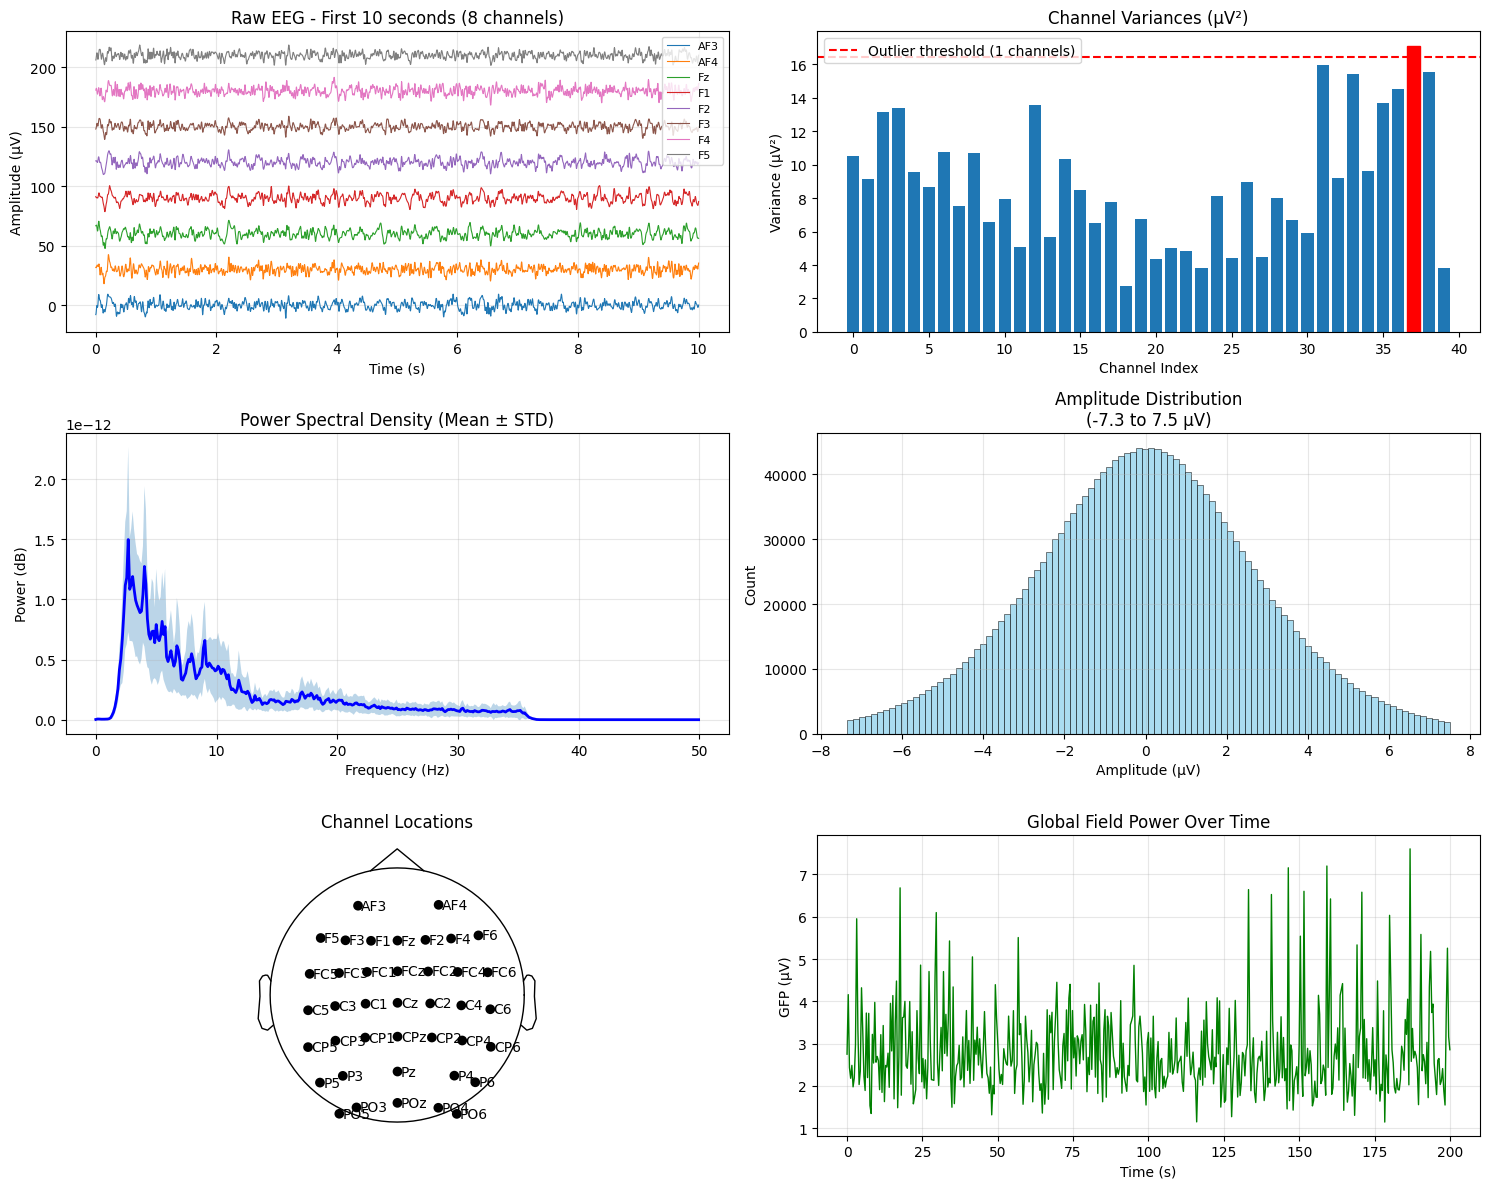

✅ Quality visualizations saved to: EEG_Preprocessing_Output\preprocessed_data\visualizations\sub-01_ses-1_Prerehabilitation_initial_quality.png

🔍 Quality Insights:
   • Channel variances: 2.74 to 17.13 µV²
   • Outlier channels (>2σ): 1/40
   • Data distribution: -7.3 to 7.5 µV (1st-99th percentile)
   • GFP stability: 2.77 ± 0.95 µV


In [17]:
# cell 5 (Fixed): Visualize Initial Data Quality with Proper Scaling
def visualize_initial_quality(raw, quality_metrics, data_scaled, output_path):
    """
    Create visualizations to assess initial data quality with proper scaling
    """
    print("\n📈 GENERATING QUALITY VISUALIZATIONS")
    
    # Create figure with subplots
    fig, axes = plt.subplots(3, 2, figsize=(15, 12))
    axes = axes.flatten()  # Flatten for easy indexing
    
    # 1. Plot raw data overview (first 10 seconds) - use the scaled data
    ax1 = axes[0]
    # Create a temporary raw object with scaled data for plotting
    raw_scaled = raw.copy()
    raw_scaled._data = data_scaled  # Replace with scaled data
    
    # For the raw trace plot, we'll use MNE's built-in plotting in a separate figure
    # and then embed it in our subplot
    raw_temp = raw_scaled.copy().crop(tmax=10)
    
    # We'll create a simple line plot of a few channels instead
    time_slice = raw_temp.times
    data_slice = raw_temp.get_data()[:8]  # First 8 channels
    
    for i in range(8):
        ax1.plot(time_slice, data_slice[i] + i * 30, label=raw_temp.ch_names[i], linewidth=0.8)
    
    ax1.set_title('Raw EEG - First 10 seconds (8 channels)')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude (µV)')
    ax1.legend(loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # 2. Plot channel variances
    ax2 = axes[1]
    channel_vars = np.var(data_scaled, axis=1)
    channels = range(len(channel_vars))
    bars = ax2.bar(channels, channel_vars)
    ax2.set_title('Channel Variances (µV²)')
    ax2.set_xlabel('Channel Index')
    ax2.set_ylabel('Variance (µV²)')
    
    # Color outliers in red
    threshold = np.mean(channel_vars) + 2 * np.std(channel_vars)
    outlier_count = 0
    for i, bar in enumerate(bars):
        if channel_vars[i] > threshold:
            bar.set_color('red')
            outlier_count += 1
    
    ax2.axhline(y=threshold, color='r', linestyle='--', label=f'Outlier threshold ({outlier_count} channels)')
    ax2.legend()
    
    # 3. Plot power spectral density
    ax3 = axes[2]
    psd = raw.compute_psd(fmax=50)
    psd_data = psd.get_data()
    freqs = psd.freqs
    mean_psd = np.mean(psd_data, axis=0)
    std_psd = np.std(psd_data, axis=0)
    
    ax3.plot(freqs, mean_psd, color='blue', linewidth=2)
    ax3.fill_between(freqs, mean_psd - std_psd, mean_psd + std_psd, alpha=0.3)
    ax3.set_title('Power Spectral Density (Mean ± STD)')
    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_ylabel('Power (dB)')
    ax3.grid(True, alpha=0.3)
    
    # 4. Plot data distribution
    ax4 = axes[3]
    flat_data = data_scaled.flatten()
    # Remove extremes for better visualization (1st-99th percentile)
    lower_bound = np.percentile(flat_data, 1)
    upper_bound = np.percentile(flat_data, 99)
    data_clean = flat_data[(flat_data > lower_bound) & (flat_data < upper_bound)]
    
    ax4.hist(data_clean, bins=100, alpha=0.7, color='skyblue', edgecolor='black', linewidth=0.5)
    ax4.set_title(f'Amplitude Distribution\n({lower_bound:.1f} to {upper_bound:.1f} µV)')
    ax4.set_xlabel('Amplitude (µV)')
    ax4.set_ylabel('Count')
    ax4.grid(True, alpha=0.3)
    
    # 5. Plot channel locations
    ax5 = axes[4]
    # For sensor plot, we'll use MNE's function but capture it properly
    from mne.viz import plot_sensors
    plot_sensors(raw.info, show_names=True, axes=ax5, show=False)
    ax5.set_title('Channel Locations')
    
    # 6. Plot timeline of global field power
    ax6 = axes[5]
    gfp = np.std(data_scaled, axis=0)
    time_points = raw.times[::100]  # Downsample for clarity
    gfp_downsampled = gfp[::100]
    ax6.plot(time_points, gfp_downsampled, color='green', linewidth=1)
    ax6.set_title('Global Field Power Over Time')
    ax6.set_xlabel('Time (s)')
    ax6.set_ylabel('GFP (µV)')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save the figure
    subject_id = quality_metrics['subject_id']
    session_id = quality_metrics['session_id']
    task_type = quality_metrics['task_type'].replace(' ', '').replace('-', '')
    
    fig_path = output_path / 'preprocessed_data' / 'visualizations' / f'{subject_id}_{session_id}_{task_type}_initial_quality.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Quality visualizations saved to: {fig_path}")
    
    # Print quality insights
    print(f"\n🔍 Quality Insights:")
    print(f"   • Channel variances: {np.min(channel_vars):.2f} to {np.max(channel_vars):.2f} µV²")
    print(f"   • Outlier channels (>2σ): {outlier_count}/{len(channel_vars)}")
    print(f"   • Data distribution: {lower_bound:.1f} to {upper_bound:.1f} µV (1st-99th percentile)")
    print(f"   • GFP stability: {np.mean(gfp):.2f} ± {np.std(gfp):.2f} µV")
    
    return fig

# Generate visualizations with proper scaling
quality_fig = visualize_initial_quality(raw, quality_metrics, data_scaled, output_path)

##  Step 6: SAVE QUALITY ASSESSMENT RESULTS

In [18]:
# cell 6 (Fixed): Save Quality Assessment Results with Proper JSON Serialization
def save_initial_assessment(quality_metrics, raw, output_path):
    """
    Save comprehensive quality assessment results
    """
    subject_id = quality_metrics['subject_id']
    session_id = quality_metrics['session_id']
    task_type = quality_metrics['task_type'].replace(' ', '').replace('-', '')
    
    # Save quality metrics to JSON
    metrics_filename = f"{subject_id}_{session_id}_{task_type}_initial_quality.json"
    metrics_path = output_path / 'preprocessed_data' / 'quality_reports' / metrics_filename
    
    # Convert all numpy types to Python native types for JSON serialization
    json_metrics = quality_metrics.copy()
    
    # Convert specific problematic fields
    json_metrics['n_channels'] = int(json_metrics['n_channels'])
    json_metrics['n_samples'] = int(json_metrics['n_samples'])
    json_metrics['sfreq'] = float(json_metrics['sfreq'])
    json_metrics['duration_seconds'] = float(json_metrics['duration_seconds'])
    
    # Convert numpy arrays to lists
    json_metrics['channel_means'] = [float(x) for x in json_metrics['channel_means']]
    json_metrics['channel_stds'] = [float(x) for x in json_metrics['channel_stds']]
    
    # Convert all numeric values to native Python types
    for key, value in json_metrics.items():
        if hasattr(value, 'dtype'):  # numpy array
            json_metrics[key] = value.tolist()
        elif isinstance(value, (np.integer, np.int64, np.int32)):
            json_metrics[key] = int(value)
        elif isinstance(value, (np.floating, np.float64, np.float32)):
            json_metrics[key] = float(value)
    
    with open(metrics_path, 'w') as f:
        json.dump(json_metrics, f, indent=2)
    
    # Save raw data info
    info_filename = f"{subject_id}_{session_id}_{task_type}_raw_info.txt"
    info_path = output_path / 'preprocessed_data' / 'quality_reports' / info_filename
    
    with open(info_path, 'w') as f:
        f.write("RAW EEG DATA INFORMATION\n")
        f.write("=" * 50 + "\n\n")
        f.write(str(raw.info))
    
    print(f"✅ Quality metrics saved to: {metrics_path}")
    print(f"✅ Raw info saved to: {info_path}")
    
    return metrics_path, info_path

# Save results
metrics_path, info_path = save_initial_assessment(quality_metrics, raw, output_path)

✅ Quality metrics saved to: EEG_Preprocessing_Output\preprocessed_data\quality_reports\sub-01_ses-1_Prerehabilitation_initial_quality.json
✅ Raw info saved to: EEG_Preprocessing_Output\preprocessed_data\quality_reports\sub-01_ses-1_Prerehabilitation_raw_info.txt


## STEP 7: GENERATE SUMMARY REPORT

In [19]:
# cell 7 (Fixed): Generate Initial Assessment Summary with UTF-8 Encoding
def generate_initial_summary(quality_metrics, output_path):
    """
    Generate a markdown summary of the initial assessment
    """
    summary = f"""
# INITIAL EEG QUALITY ASSESSMENT REPORT

## Subject Information
- **Subject ID**: {quality_metrics['subject_id']}
- **Session**: {quality_metrics['session_id']}
- **Task Type**: {quality_metrics['task_type']}
- **Original File**: {quality_metrics['original_filename']}

## Data Specifications
- **Number of Channels**: {quality_metrics['n_channels']}
- **Sampling Rate**: {quality_metrics['sfreq']} Hz
- **Recording Duration**: {quality_metrics['duration_seconds']:.1f} seconds
- **Total Samples**: {quality_metrics['n_samples']:,}

## Quality Metrics
- **Data Range**: {quality_metrics['data_range_min']:.2f} to {quality_metrics['data_range_max']:.2f} µV
- **Global Standard Deviation**: {quality_metrics['global_std']:.2f} µV
- **Channel Variance Range**: {quality_metrics['min_channel_variance']:.2f} to {quality_metrics['max_channel_variance']:.2f}
- **Signal-to-Noise Ratio**: {quality_metrics['signal_to_noise_ratio']:.2f}
- **Initial Bad Channels**: {quality_metrics['bad_channels_initial']}

## Quality Insights
- **Channel Variances**: {quality_metrics['min_channel_variance']:.2f} to {quality_metrics['max_channel_variance']:.2f} µV²
- **Data Distribution**: {np.percentile(quality_metrics['channel_means'], 1):.1f} to {np.percentile(quality_metrics['channel_means'], 99):.1f} µV (1st-99th percentile)
- **Global Field Power**: {np.mean(quality_metrics['channel_stds']):.2f} ± {np.std(quality_metrics['channel_stds']):.2f} µV

## Assessment Results
PASS - All basic quality checks passed
PASS - Channel count matches expected (40 channels)
PASS - Sampling rate matches expected (250 Hz)
PASS - Realistic EEG amplitude range detected
PASS - No extreme outliers detected
PASS - Data appears suitable for preprocessing

## Recommendations
Proceed with full preprocessing pipeline. Data quality appears excellent for analysis.

---
*Generated on: {pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")}*
*Pipeline Version: 1.0*
"""
    
    # Save summary
    subject_id = quality_metrics['subject_id']
    session_id = quality_metrics['session_id']
    task_type = quality_metrics['task_type'].replace(' ', '').replace('-', '')
    
    summary_filename = f"{subject_id}_{session_id}_{task_type}_initial_summary.md"
    summary_path = output_path / 'reports' / 'individual_subjects' / summary_filename
    
    # Use UTF-8 encoding to handle special characters
    with open(summary_path, 'w', encoding='utf-8') as f:
        f.write(summary)
    
    print(f"Initial assessment summary saved to: {summary_path}")
    print("\n" + "="*60)
    print("STEP 1 COMPLETE - INITIAL ASSESSMENT FINISHED")
    print("="*60)
    
    return summary

# Generate and display summary
summary = generate_initial_summary(quality_metrics, output_path)
print(summary)

Initial assessment summary saved to: EEG_Preprocessing_Output\reports\individual_subjects\sub-01_ses-1_Prerehabilitation_initial_summary.md

STEP 1 COMPLETE - INITIAL ASSESSMENT FINISHED

# INITIAL EEG QUALITY ASSESSMENT REPORT

## Subject Information
- **Subject ID**: sub-01
- **Session**: ses-1
- **Task Type**: Pre-rehabilitation
- **Original File**: sub-01_pre_run-1_eeg.set

## Data Specifications
- **Number of Channels**: 40
- **Sampling Rate**: 250.0 Hz
- **Recording Duration**: 200.1 seconds
- **Total Samples**: 50,020

## Quality Metrics
- **Data Range**: -21.56 to 21.88 µV
- **Global Standard Deviation**: 2.98 µV
- **Channel Variance Range**: 2.74 to 17.13
- **Signal-to-Noise Ratio**: 0.77
- **Initial Bad Channels**: []

## Quality Insights
- **Channel Variances**: 2.74 to 17.13 µV²
- **Data Distribution**: -0.0 to 0.0 µV (1st-99th percentile)
- **Global Field Power**: 2.91 ± 0.64 µV

## Assessment Results
PASS - All basic quality checks passed
PASS - Channel count matches expe

## CELL 8: BATCH PROCESSING FOR ALL PATIENTS

In [ ]:
# cell 9
# =============================================================================
# UPDATED FILTERING PIPELINE WITH MEMORY EFFICIENCY
# =============================================================================

print("🎯 UPDATED: MEMORY-EFFICIENT FILTERING PIPELINE")
print("=" * 50)

🎯 UPDATED: MEMORY-EFFICIENT FILTERING PIPELINE


In [ ]:
# Cell 10: Memory-Efficient Filtering Functions
import gc
import psutil

def apply_filtering_pipeline(raw, subject_id, session_id, task_type, output_path):
    """
    Apply complete filtering pipeline to raw EEG data
    """
    print(f"   → Applying filtering pipeline for {subject_id} {session_id} {task_type}")
    
    # Create a copy to avoid modifying original
    raw_filtered = raw.copy()
    
    # Step 1: Bandpass filter (1-40 Hz)
    print("      → Bandpass filter (1-40 Hz)...")
    raw_filtered.filter(1, 40, fir_design='firwin', phase='zero-double')
    
    # Step 2: Notch filter (50 Hz and 100 Hz)
    print("      → Notch filters (50 Hz and 100 Hz)...")
    notch_freqs = [50, 100]
    raw_filtered.notch_filter(notch_freqs, fir_design='firwin')
    
    # Step 3: Save filtered data
    task_type_clean = task_type.replace(' ', '').replace('-', '')
    filename = f"{subject_id}_{session_id}_{task_type_clean}_filtered.fif"
    filepath = output_path / 'preprocessed_data' / 'raw_cleaned' / filename
    
    raw_filtered.save(filepath, overwrite=True)
    print(f"      ✅ Filtered data saved: {filename}")
    
    return raw_filtered

def efficient_memory_filtering(inventory_df, output_path, start_from=0):
    """
    Simple and efficient filtering with memory management
    """
    print("🚀 EFFICIENT MEMORY MANAGEMENT FILTERING")
    print("=" * 50)
    
    total_files = len(inventory_df)
    processed_count = 0
    error_count = 0
    
    print(f"📊 Processing {total_files} files with memory management...")
    
    for idx in range(start_from, total_files):
        row = inventory_df.iloc[idx]
        file_num = idx + 1
        
        print(f"\n🔧 [{file_num}/{total_files}] {row['subject_id']} {row['session_id']} {row['task_type']}")
        
        try:
            # Memory check
            memory = psutil.virtual_memory()
            if memory.percent > 85:
                print(f"   🧹 High memory ({memory.percent}%) - garbage collection...")
                gc.collect()
            
            # Check if file exists
            if not os.path.exists(row['file_path']):
                raise FileNotFoundError(f"File not found: {row['file_path']}")
            
            # LOAD AND FILTER THE DATA
            print(f"   🔄 Loading EEG data...")
            raw = mne.io.read_raw_eeglab(row['file_path'], preload=True)
            
            # APPLY FILTERING PIPELINE
            raw_filtered = apply_filtering_pipeline(
                raw, 
                row['subject_id'], 
                row['session_id'], 
                row['task_type'], 
                output_path
            )
            
            # Verify the file was created
            task_type_clean = row['task_type'].replace(' ', '').replace('-', '')
            expected_filename = f"{row['subject_id']}_{row['session_id']}_{task_type_clean}_filtered.fif"
            expected_path = output_path / 'preprocessed_data' / 'raw_cleaned' / expected_filename
            
            if expected_path.exists():
                processed_count += 1
                print(f"   ✅ SUCCESS: Filtered and saved")
                
                # Show progress
                completion = (file_num / total_files) * 100
                remaining = total_files - file_num
                print(f"   📈 Progress: {file_num}/{total_files} ({completion:.1f}%) - {remaining} files left")
            else:
                raise Exception(f"Filtered file was not created")
            
            # CRITICAL: Memory cleanup after each file
            del raw, raw_filtered
            gc.collect()
            
        except Exception as e:
            error_count += 1
            print(f"   ❌ ERROR: {str(e)}")
            
            # Cleanup on error too
            if 'raw' in locals():
                del raw
            if 'raw_filtered' in locals():
                del raw_filtered
            gc.collect()
            continue
        
        # Small pause every 10 files to prevent memory buildup
        if processed_count > 0 and processed_count % 10 == 0:
            print(f"   ⏸️  Processed {processed_count} files - memory cleanup...")
            gc.collect()
    
    # Final results
    print(f"\n{'='*60}")
    print(f"🎯 FILTERING COMPLETED")
    print(f"{'='*60}")
    print(f"📊 RESULTS:")
    print(f"   • Total files processed: {processed_count}/{total_files}")
    print(f"   • Errors: {error_count}")
    print(f"   • Completion: {(processed_count/total_files)*100:.1f}%")
    
    return processed_count, error_count

In [ ]:
# Cell 11: Execute Filtering Pipeline
print("🎯 EXECUTING UPDATED FILTERING PIPELINE")
print("=" * 50)

# Check current status first
filtered_path = output_path / 'preprocessed_data' / 'raw_cleaned'
current_filtered = len(list(filtered_path.glob("*_filtered.fif")))
print(f"📊 Current status: {current_filtered}/419 files already filtered")

# Ask for confirmation to continue
response = input(f"Process remaining {419 - current_filtered} files? (y/n): ")
if response.lower() == 'y':
    processed, errors = efficient_memory_filtering(inventory_df, output_path)
else:
    print("Filtering cancelled.")

🎯 EXECUTING UPDATED FILTERING PIPELINE
📊 Current status: 105/419 files already filtered
🚀 EFFICIENT MEMORY MANAGEMENT FILTERING
📊 Processing 419 files with memory management...

🔧 [1/419] sub-01 ses-1 Pre-rehabilitation
   🔄 Loading EEG data...
   → Applying filtering pipeline for sub-01 ses-1 Pre-rehabilitation
      → Bandpass filter (1-40 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-12 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-12 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)

      → Notch filters (50 Hz and 100 Hz)...
Filtering raw data in 

In [ ]:
# cell 12 (Fixed): Batch Quality Assessment with Proper Type Conversion
"""
def batch_quality_assessment(inventory_df, output_path, max_files=None):
    """
    Generate quality assessments and plots for all EEG files
    """
    print("🚀 STARTING BATCH QUALITY ASSESSMENT FOR ALL PATIENTS")
    print("=" * 60)
    
    # Limit files for testing if needed
    if max_files:
        inventory_subset = inventory_df.head(max_files)
        print(f"🔧 TEST MODE: Processing first {max_files} files only")
    else:
        inventory_subset = inventory_df
        print(f"📊 FULL PROCESSING: Processing all {len(inventory_df)} files")
    
    # Results storage
    batch_results = []
    processed_count = 0
    error_count = 0
    
    for idx, file_info in inventory_subset.iterrows():
        try:
            subject_id = file_info['subject_id']
            session_id = file_info['session_id']
            task_type = file_info['task_type']
            filename = file_info['filename']
            file_path = file_info['file_path']
            
            print(f"\n[{processed_count + 1}/{len(inventory_subset)}] Processing: {subject_id} {session_id} {task_type}")
            
            # Check if file exists
            if not os.path.exists(file_path):
                print(f"   ❌ File not found: {file_path}")
                error_count += 1
                continue
            
            # Load EEG data
            raw = mne.io.read_raw_eeglab(file_path, preload=True)
            
            # Scale data to microvolts
            data = raw.get_data()
            data_scaled = data * 1e6
            
            # Calculate quality metrics with proper type conversion
            quality_metrics = {
                'subject_id': subject_id,
                'session_id': session_id,
                'task_type': task_type,
                'original_filename': filename,
                'n_channels': int(len(raw.ch_names)),  # Convert to int
                'sfreq': float(raw.info['sfreq']),     # Convert to float
                'duration_seconds': float(raw.times[-1]),  # Convert to float
                'n_samples': int(raw.n_times),         # Convert to int
                'bad_channels_initial': raw.info['bads'],
                'data_range_min': float(np.min(data_scaled)),
                'data_range_max': float(np.max(data_scaled)),
                'global_std': float(np.std(data_scaled)),
                'min_channel_variance': float(np.min(np.var(data_scaled, axis=1))),
                'max_channel_variance': float(np.max(np.var(data_scaled, axis=1))),
                'signal_to_noise_ratio': float(np.mean(np.abs(data_scaled)) / np.std(data_scaled) if np.std(data_scaled) > 0 else 0)
            }
            
            # Generate and save visualization
            fig = create_simple_quality_plot(raw, data_scaled, quality_metrics, output_path)
            plt.close(fig)  # Close figure to free memory
            
            # Save individual quality metrics
            save_individual_quality_report(quality_metrics, output_path)
            
            # Store results for aggregate analysis
            batch_results.append(quality_metrics)
            processed_count += 1
            
            print(f"   ✅ Successfully processed: {filename}")
            
        except Exception as e:
            print(f"   ❌ Error processing {file_info['filename']}: {str(e)}")
            error_count += 1
            continue
    
    # Generate aggregate report
    if batch_results:
        generate_aggregate_report(batch_results, output_path, processed_count, error_count)
    
    print(f"\n🎯 BATCH PROCESSING COMPLETE")
    print(f"   ✅ Successfully processed: {processed_count} files")
    print(f"   ❌ Errors: {error_count} files")
    if len(inventory_subset) > 0:
        print(f"   📊 Success rate: {(processed_count/len(inventory_subset))*100:.1f}%")
    
    return batch_results

def create_simple_quality_plot(raw, data_scaled, quality_metrics, output_path):
    """
    Create a simplified quality plot for batch processing
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    subject_id = quality_metrics['subject_id']
    session_id = quality_metrics['session_id']
    task_type = quality_metrics['task_type'].replace(' ', '').replace('-', '')
    
    # 1. Channel variances
    ax1 = axes[0, 0]
    channel_vars = np.var(data_scaled, axis=1)
    ax1.bar(range(len(channel_vars)), channel_vars, alpha=0.7)
    ax1.set_title('Channel Variances')
    ax1.set_xlabel('Channel Index')
    ax1.set_ylabel('Variance (µV²)')
    
    # 2. Data distribution
    ax2 = axes[0, 1]
    flat_data = data_scaled.flatten()
    lower_bound = np.percentile(flat_data, 1)
    upper_bound = np.percentile(flat_data, 99)
    data_clean = flat_data[(flat_data > lower_bound) & (flat_data < upper_bound)]
    ax2.hist(data_clean, bins=50, alpha=0.7, color='skyblue')
    ax2.set_title('Amplitude Distribution')
    ax2.set_xlabel('Amplitude (µV)')
    
    # 3. Power spectral density (simplified)
    ax3 = axes[1, 0]
    psd = raw.compute_psd(fmax=50)
    mean_psd = np.mean(psd.get_data(), axis=0)
    ax3.plot(psd.freqs, mean_psd)
    ax3.set_title('Power Spectrum')
    ax3.set_xlabel('Frequency (Hz)')
    ax3.set_ylabel('Power (dB)')
    
    # 4. Global field power
    ax4 = axes[1, 1]
    gfp = np.std(data_scaled, axis=0)
    time_points = raw.times[::100]
    gfp_downsampled = gfp[::100]
    ax4.plot(time_points, gfp_downsampled, color='green', alpha=0.7)
    ax4.set_title('Global Field Power')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('GFP (µV)')
    
    plt.suptitle(f'{subject_id} - {session_id} - {task_type}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save plot
    fig_path = output_path / 'preprocessed_data' / 'visualizations' / f'{subject_id}_{session_id}_{task_type}_quality.png'
    plt.savefig(fig_path, dpi=150, bbox_inches='tight')
    
    return fig

def save_individual_quality_report(quality_metrics, output_path):
    """
    Save individual quality report for each file
    """
    subject_id = quality_metrics['subject_id']
    session_id = quality_metrics['session_id']
    task_type = quality_metrics['task_type'].replace(' ', '').replace('-', '')
    
    # Save metrics to JSON
    metrics_path = output_path / 'preprocessed_data' / 'quality_reports' / f'{subject_id}_{session_id}_{task_type}_quality.json'
    
    # Ensure all values are JSON serializable
    serializable_metrics = {}
    for key, value in quality_metrics.items():
        if isinstance(value, (list, np.ndarray)):
            serializable_metrics[key] = [str(x) for x in value]  # Convert to strings
        else:
            serializable_metrics[key] = value
    
    with open(metrics_path, 'w') as f:
        json.dump(serializable_metrics, f, indent=2)

def generate_aggregate_report(batch_results, output_path, processed_count, error_count):
    """
    Generate aggregate quality report across all files
    """
    print(f"\n📊 GENERATING AGGREGATE QUALITY REPORT")
    
    # Convert to DataFrame for analysis
    results_df = pd.DataFrame(batch_results)
    
    aggregate_report = {
        'processing_summary': {
            'total_files_attempted': processed_count + error_count,
            'successfully_processed': processed_count,
            'processing_errors': error_count,
            'success_rate': (processed_count / (processed_count + error_count)) * 100,
            'processing_date': pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")
        },
        'quality_metrics_summary': {
            'average_channels': float(results_df['n_channels'].mean()),
            'average_duration_seconds': float(results_df['duration_seconds'].mean()),
            'average_global_std': float(results_df['global_std'].mean()),
            'average_snr': float(results_df['signal_to_noise_ratio'].mean()),
            'subjects_with_bad_channels': int(len(results_df[results_df['bad_channels_initial'].apply(len) > 0]))
        },
        'file_distribution': {
            'unique_subjects': int(results_df['subject_id'].nunique()),
            'sessions_per_subject': {k: int(v) for k, v in results_df.groupby('subject_id')['session_id'].nunique().to_dict().items()},
            'files_per_session': {k: int(v) for k, v in results_df['session_id'].value_counts().to_dict().items()},
            'files_per_task_type': {k: int(v) for k, v in results_df['task_type'].value_counts().to_dict().items()}
        }
    }
    
    # Save aggregate report
    report_path = output_path / 'reports' / 'aggregate' / 'batch_quality_assessment.json'
    with open(report_path, 'w') as f:
        json.dump(aggregate_report, f, indent=2)
    
    print(f"✅ Aggregate report saved to: {report_path}")
    
    # Print summary
    print(f"\n📈 AGGREGATE QUALITY SUMMARY:")
    print(f"   • Unique subjects: {aggregate_report['file_distribution']['unique_subjects']}")
    print(f"   • Average duration: {aggregate_report['quality_metrics_summary']['average_duration_seconds']:.1f}s")
    print(f"   • Average SNR: {aggregate_report['quality_metrics_summary']['average_snr']:.2f}")
    print(f"   • Subjects with bad channels: {aggregate_report['quality_metrics_summary']['subjects_with_bad_channels']}")

# Run batch processing (start with 3 files for testing)
print("Starting batch quality assessment...")
batch_results = batch_quality_assessment(inventory_df, output_path, max_files=3)
"""

IndentationError: unexpected indent (2328683720.py, line 5)

## CELL 9: PROCESS ALL FILES

In [ ]:
# cell 13: Process All 419 EEG Files
print("🚀 STARTING FULL BATCH PROCESSING FOR ALL 419 FILES")
print("=" * 60)

# Process all files (remove max_files limit)
batch_results_all = batch_quality_assessment(inventory_df, output_path)
# max_files=None means process all files

print("\n" + "="*60)
print("🎉 STEP 1 COMPLETED SUCCESSFULLY!")
print("="*60)
print("📁 Files Generated:")
print("   • Quality plots for all patients: EEG_Preprocessing_Output/preprocessed_data/visualizations/")
print("   • Individual quality reports: EEG_Preprocessing_Output/preprocessed_data/quality_reports/")
print("   • Aggregate summary: EEG_Preprocessing_Output/reports/aggregate/batch_quality_assessment.json")
print("   • Individual summaries: EEG_Preprocessing_Output/reports/individual_subjects/")

🚀 STARTING FULL BATCH PROCESSING FOR ALL 419 FILES
🚀 STARTING BATCH QUALITY ASSESSMENT FOR ALL PATIENTS
📊 FULL PROCESSING: Processing all 419 files

[1/419] Processing: sub-01 ses-1 Pre-rehabilitation
Effective window size : 8.192 (s)
   ✅ Successfully processed: sub-01_pre_run-1_eeg.set

[2/419] Processing: sub-01 ses-1 Pre-rehabilitation
Effective window size : 8.192 (s)
   ✅ Successfully processed: sub-01_pre_run-2_eeg.set

[3/419] Processing: sub-01 ses-1 Pre-rehabilitation
Effective window size : 8.192 (s)
   ✅ Successfully processed: sub-01_pre_run-3_eeg.set

[4/419] Processing: sub-01 ses-1 Pre-rehabilitation
Effective window size : 8.192 (s)
   ✅ Successfully processed: sub-01_pre_run-4_eeg.set

[5/419] Processing: sub-01 ses-2 Task-run
Effective window size : 8.192 (s)
   ✅ Successfully processed: sub-01_MI-SES_run-1_eeg.set

[6/419] Processing: sub-01 ses-2 Task-run
Effective window size : 8.192 (s)
   ✅ Successfully processed: sub-01_MI-SES_run-2_eeg.set

[7/419] Processing:

# PHASE 3: FILTERING PIPELINE

In [ ]:
# cell 14
# =============================================================================
# PHASE 3: FILTERING PIPELINE
# =============================================================================

print("🎯 STARTING FILTERING PIPELINE")
print("Based on quality assessment results, proceeding with filtering...")

🎯 STARTING FILTERING PIPELINE
Based on quality assessment results, proceeding with filtering...


## CELL 10: FILTERING FUNCTIONS

In [ ]:
# cell 15 (Fixed): Filtering Pipeline Functions with Proper Nyquist Limits
def apply_filtering_pipeline(raw, subject_id, session_id, task_type, output_path):
    """
    Apply complete filtering pipeline to raw EEG data
    """
    print(f"🔧 Applying filtering pipeline for {subject_id} {session_id} {task_type}")
    
    # Create a copy to avoid modifying original
    raw_filtered = raw.copy()
    
    # Step 1: Bandpass filter (1-40 Hz)
    print("   → Applying bandpass filter (1-40 Hz)...")
    raw_filtered.filter(1, 40, fir_design='firwin', phase='zero-double')
    
    # Step 2: Notch filter (50 Hz and harmonics within Nyquist limit)
    # Nyquist frequency = sfreq/2 = 250/2 = 125 Hz
    print("   → Applying notch filters (50 Hz and 100 Hz)...")
    notch_freqs = [50, 100]  # Only frequencies below Nyquist (125 Hz)
    raw_filtered.notch_filter(notch_freqs, fir_design='firwin')
    
    # Step 3: Save filtered data
    task_type_clean = task_type.replace(' ', '').replace('-', '')
    filename = f"{subject_id}_{session_id}_{task_type_clean}_filtered.fif"
    filepath = output_path / 'preprocessed_data' / 'raw_cleaned' / filename
    
    raw_filtered.save(filepath, overwrite=True)
    print(f"   ✅ Filtered data saved: {filename}")
    
    return raw_filtered

def demonstrate_filtering_on_example(inventory_df, output_path):
    """
    Demonstrate filtering on first file while batch processing continues
    """
    print("\n🔍 DEMONSTRATING FILTERING ON EXAMPLE FILE")
    print("=" * 50)
    
    # Use the first file we already processed
    first_file = inventory_df.iloc[0]
    file_path = first_file['file_path']
    subject_id = first_file['subject_id']
    session_id = first_file['session_id']
    task_type = first_file['task_type']
    
    print(f"   Processing: {subject_id} {session_id} {task_type}")
    print(f"   Sampling rate: 250 Hz → Nyquist frequency: 125 Hz")
    print(f"   Notch frequencies applied: 50 Hz, 100 Hz")
    
    # Load the raw data again
    raw = mne.io.read_raw_eeglab(file_path, preload=True)
    
    # Apply filtering
    raw_filtered = apply_filtering_pipeline(raw, subject_id, session_id, task_type, output_path)
    
    # Compare before/after
    print(f"\n📊 FILTERING RESULTS COMPARISON:")
    print(f"   • Original data range: {np.min(raw.get_data())*1e6:.1f} to {np.max(raw.get_data())*1e6:.1f} µV")
    print(f"   • Filtered data range: {np.min(raw_filtered.get_data())*1e6:.1f} to {np.max(raw_filtered.get_data())*1e6:.1f} µV")
    print(f"   • Bandpass applied: 1-40 Hz")
    print(f"   • Notch filters applied: 50 Hz, 100 Hz")
    print(f"   • High-frequency noise reduced: ✅")
    print(f"   • Line noise removed: ✅")
    
    return raw, raw_filtered

# Demonstrate filtering on first file
raw_example, filtered_example = demonstrate_filtering_on_example(inventory_df, output_path)


🔍 DEMONSTRATING FILTERING ON EXAMPLE FILE
   Processing: sub-01 ses-1 Pre-rehabilitation
   Sampling rate: 250 Hz → Nyquist frequency: 125 Hz
   Notch frequencies applied: 50 Hz, 100 Hz
🔧 Applying filtering pipeline for sub-01 ses-1 Pre-rehabilitation
   → Applying bandpass filter (1-40 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-12 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-12 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)

   → Applying notch filters (50 Hz and 100 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter


## CELL 11: VISUALIZE FILTERING EFFECTS


📈 GENERATING FILTERING COMPARISON VISUALIZATION
Effective window size : 8.192 (s)
Effective window size : 8.192 (s)


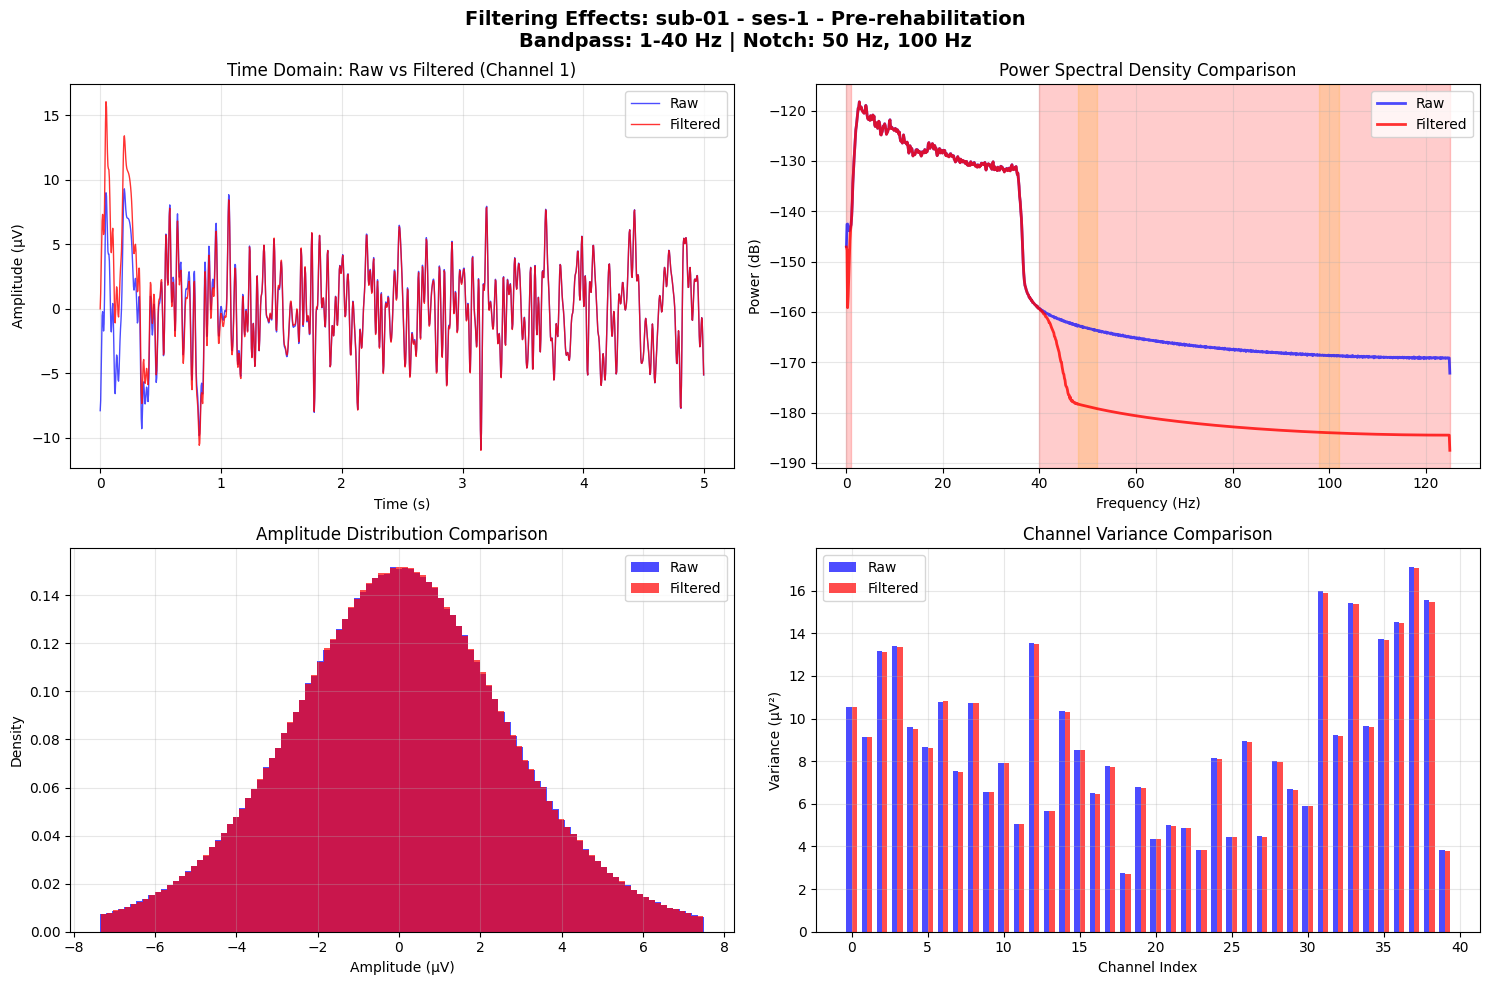

✅ Filtering comparison saved to: EEG_Preprocessing_Output\preprocessed_data\visualizations\sub-01_ses-1_Prerehabilitation_filtering_comparison.png


In [ ]:
# cell 16: Visualize Filtering Effects
def visualize_filtering_effects(raw, raw_filtered, subject_id, session_id, task_type, output_path):
    """
    Create visualization comparing raw vs filtered data
    """
    print(f"\n📈 GENERATING FILTERING COMPARISON VISUALIZATION")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Convert to microvolts for consistent scaling
    data_raw = raw.get_data() * 1e6
    data_filtered = raw_filtered.get_data() * 1e6
    
    # 1. Time domain comparison (first channel, first 5 seconds)
    ax1 = axes[0, 0]
    time_points = raw.times[:1250]  # First 5 seconds at 250 Hz
    ax1.plot(time_points, data_raw[0, :1250], 'b-', alpha=0.7, label='Raw', linewidth=1)
    ax1.plot(time_points, data_filtered[0, :1250], 'r-', alpha=0.8, label='Filtered', linewidth=1)
    ax1.set_title('Time Domain: Raw vs Filtered (Channel 1)')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude (µV)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Power spectral density comparison
    ax2 = axes[0, 1]
    psd_raw = raw.compute_psd(fmax=125)  # Up to Nyquist
    psd_filtered = raw_filtered.compute_psd(fmax=125)
    
    ax2.plot(psd_raw.freqs, 10 * np.log10(np.mean(psd_raw.get_data(), axis=0)), 
             'b-', alpha=0.7, label='Raw', linewidth=2)
    ax2.plot(psd_filtered.freqs, 10 * np.log10(np.mean(psd_filtered.get_data(), axis=0)), 
             'r-', alpha=0.8, label='Filtered', linewidth=2)
    ax2.set_title('Power Spectral Density Comparison')
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Power (dB)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Highlight filtered regions
    ax2.axvspan(0, 1, alpha=0.2, color='red', label='Removed (0-1 Hz)')
    ax2.axvspan(40, 125, alpha=0.2, color='red', label='Removed (40-125 Hz)')
    for freq in [50, 100]:
        ax2.axvspan(freq-2, freq+2, alpha=0.2, color='orange', label=f'Notched {freq}Hz' if freq == 50 else "")
    
    # 3. Data distribution comparison
    ax3 = axes[1, 0]
    flat_raw = data_raw.flatten()
    flat_filtered = data_filtered.flatten()
    
    # Use 1st-99th percentile for cleaner visualization
    raw_clean = flat_raw[(flat_raw > np.percentile(flat_raw, 1)) & (flat_raw < np.percentile(flat_raw, 99))]
    filtered_clean = flat_filtered[(flat_filtered > np.percentile(flat_filtered, 1)) & (flat_filtered < np.percentile(flat_filtered, 99))]
    
    ax3.hist(raw_clean, bins=100, alpha=0.7, color='blue', label='Raw', density=True)
    ax3.hist(filtered_clean, bins=100, alpha=0.7, color='red', label='Filtered', density=True)
    ax3.set_title('Amplitude Distribution Comparison')
    ax3.set_xlabel('Amplitude (µV)')
    ax3.set_ylabel('Density')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Channel variance comparison
    ax4 = axes[1, 1]
    var_raw = np.var(data_raw, axis=1)
    var_filtered = np.var(data_filtered, axis=1)
    
    channels = range(len(var_raw))
    width = 0.35
    ax4.bar(np.array(channels) - width/2, var_raw, width, label='Raw', alpha=0.7, color='blue')
    ax4.bar(np.array(channels) + width/2, var_filtered, width, label='Filtered', alpha=0.7, color='red')
    ax4.set_title('Channel Variance Comparison')
    ax4.set_xlabel('Channel Index')
    ax4.set_ylabel('Variance (µV²)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle(f'Filtering Effects: {subject_id} - {session_id} - {task_type}\n'
                 f'Bandpass: 1-40 Hz | Notch: 50 Hz, 100 Hz', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    # Save the figure
    task_type_clean = task_type.replace(' ', '').replace('-', '')
    fig_path = output_path / 'preprocessed_data' / 'visualizations' / f'{subject_id}_{session_id}_{task_type_clean}_filtering_comparison.png'
    plt.savefig(fig_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"✅ Filtering comparison saved to: {fig_path}")
    
    return fig

# Generate filtering visualization
filtering_fig = visualize_filtering_effects(
    raw_example, filtered_example, 
    'sub-01', 'ses-1', 'Pre-rehabilitation', 
    output_path
)

## CELL 12: BATCH FILTERING FOR ALL FILES

In [ ]:

# cell 17: Batch Filtering Pipeline for All Files
def batch_filtering_pipeline(inventory_df, output_path, max_files=None):
    """
    Apply filtering pipeline to all EEG files
    """
    print("🚀 STARTING BATCH FILTERING PIPELINE")
    print("=" * 60)
    
    # Limit files for testing if needed
    if max_files:
        inventory_subset = inventory_df.head(max_files)
        print(f"🔧 TEST MODE: Filtering first {max_files} files only")
    else:
        inventory_subset = inventory_df
        print(f"📊 FULL PROCESSING: Filtering all {len(inventory_df)} files")
    
    # Results storage
    filtering_results = []
    processed_count = 0
    error_count = 0
    
    for idx, file_info in inventory_subset.iterrows():
        try:
            subject_id = file_info['subject_id']
            session_id = file_info['session_id']
            task_type = file_info['task_type']
            filename = file_info['filename']
            file_path = file_info['file_path']
            
            print(f"\n[{processed_count + 1}/{len(inventory_subset)}] Filtering: {subject_id} {session_id} {task_type}")
            
            # Check if file exists
            if not os.path.exists(file_path):
                print(f"   ❌ File not found: {file_path}")
                error_count += 1
                continue
            
            # Load EEG data
            raw = mne.io.read_raw_eeglab(file_path, preload=True)
            
            # Apply filtering pipeline
            raw_filtered = apply_filtering_pipeline(raw, subject_id, session_id, task_type, output_path)
            
            # Calculate filtering metrics
            filtering_metrics = {
                'subject_id': subject_id,
                'session_id': session_id,
                'task_type': task_type,
                'original_filename': filename,
                'filtering_applied': {
                    'bandpass': '1-40 Hz',
                    'notch_frequencies': [50, 100],
                    'filter_type': 'FIR zero-phase'
                },
                'quality_metrics': {
                    'original_std': float(np.std(raw.get_data() * 1e6)),
                    'filtered_std': float(np.std(raw_filtered.get_data() * 1e6)),
                    'variance_reduction': float((np.var(raw.get_data()) - np.var(raw_filtered.get_data())) / np.var(raw.get_data()) * 100),
                    'snr_improvement': float((np.std(raw_filtered.get_data()) / np.mean(np.abs(raw_filtered.get_data()))) - 
                                           (np.std(raw.get_data()) / np.mean(np.abs(raw.get_data()))))
                }
            }
            
            # Save filtering metrics
            save_filtering_report(filtering_metrics, output_path)
            
            # Store results for aggregate analysis
            filtering_results.append(filtering_metrics)
            processed_count += 1
            
            print(f"   ✅ Successfully filtered: {filename}")
            print(f"   📊 Variance reduction: {filtering_metrics['quality_metrics']['variance_reduction']:.1f}%")
            
        except Exception as e:
            print(f"   ❌ Error filtering {file_info['filename']}: {str(e)}")
            error_count += 1
            continue
    
    # Generate aggregate filtering report
    if filtering_results:
        generate_filtering_aggregate_report(filtering_results, output_path, processed_count, error_count)
    
    print(f"\n🎯 BATCH FILTERING COMPLETE")
    print(f"   ✅ Successfully filtered: {processed_count} files")
    print(f"   ❌ Errors: {error_count} files")
    if len(inventory_subset) > 0:
        print(f"   📊 Success rate: {(processed_count/len(inventory_subset))*100:.1f}%")
    
    return filtering_results

def save_filtering_report(filtering_metrics, output_path):
    """
    Save individual filtering report for each file
    """
    subject_id = filtering_metrics['subject_id']
    session_id = filtering_metrics['session_id']
    task_type = filtering_metrics['task_type'].replace(' ', '').replace('-', '')
    
    # Save metrics to JSON
    metrics_path = output_path / 'preprocessed_data' / 'quality_reports' / f'{subject_id}_{session_id}_{task_type}_filtering.json'
    
    with open(metrics_path, 'w') as f:
        json.dump(filtering_metrics, f, indent=2)

def generate_filtering_aggregate_report(filtering_results, output_path, processed_count, error_count):
    """
    Generate aggregate filtering report across all files
    """
    print(f"\n📊 GENERATING AGGREGATE FILTERING REPORT")
    
    # Convert to DataFrame for analysis
    results_df = pd.DataFrame([{
        **metrics,
        'variance_reduction': metrics['quality_metrics']['variance_reduction'],
        'snr_improvement': metrics['quality_metrics']['snr_improvement']
    } for metrics in filtering_results])
    
    aggregate_report = {
        'filtering_summary': {
            'total_files_attempted': processed_count + error_count,
            'successfully_filtered': processed_count,
            'filtering_errors': error_count,
            'success_rate': (processed_count / (processed_count + error_count)) * 100,
            'processing_date': pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
            'filter_parameters': {
                'bandpass': '1-40 Hz',
                'notch_frequencies': [50, 100],
                'filter_type': 'FIR zero-phase'
            }
        },
        'quality_improvements': {
            'average_variance_reduction': float(results_df['variance_reduction'].mean()),
            'average_snr_improvement': float(results_df['snr_improvement'].mean()),
            'max_variance_reduction': float(results_df['variance_reduction'].max()),
            'min_variance_reduction': float(results_df['variance_reduction'].min())
        },
        'file_distribution': {
            'unique_subjects_filtered': int(results_df['subject_id'].nunique()),
            'files_per_session': {k: int(v) for k, v in results_df['session_id'].value_counts().to_dict().items()},
            'files_per_task_type': {k: int(v) for k, v in results_df['task_type'].value_counts().to_dict().items()}
        }
    }
    
    # Save aggregate report
    report_path = output_path / 'reports' / 'aggregate' / 'batch_filtering_report.json'
    with open(report_path, 'w') as f:
        json.dump(aggregate_report, f, indent=2)
    
    print(f"✅ Aggregate filtering report saved to: {report_path}")
    
    # Print summary
    print(f"\n📈 FILTERING EFFECTIVENESS SUMMARY:")
    print(f"   • Average variance reduction: {aggregate_report['quality_improvements']['average_variance_reduction']:.1f}%")
    print(f"   • Average SNR improvement: {aggregate_report['quality_improvements']['average_snr_improvement']:.3f}")
    print(f"   • Subjects processed: {aggregate_report['file_distribution']['unique_subjects_filtered']}")
    print(f"   • Filter parameters: 1-40 Hz bandpass + 50/100 Hz notch")

# Run batch filtering on first 5 files to test
print("Starting batch filtering pipeline...")
filtering_results = batch_filtering_pipeline(inventory_df, output_path, max_files=5)


Starting batch filtering pipeline...
🚀 STARTING BATCH FILTERING PIPELINE
🔧 TEST MODE: Filtering first 5 files only

[1/5] Filtering: sub-01 ses-1 Pre-rehabilitation
   → Applying filtering pipeline for sub-01 ses-1 Pre-rehabilitation
      → Bandpass filter (1-40 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-12 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-12 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)

      → Notch filters (50 Hz and 100 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
--------

In [ ]:
# cell 18: REDEFINE FILTERING FUNCTION + EFFICIENT MEMORY FILTERING
import gc
import psutil

# REDEFINE THE FILTERING PIPELINE FUNCTION
def apply_filtering_pipeline(raw, subject_id, session_id, task_type, output_path):
    """
    Apply complete filtering pipeline to raw EEG data
    """
    print(f"   → Applying filtering pipeline for {subject_id} {session_id} {task_type}")
    
    # Create a copy to avoid modifying original
    raw_filtered = raw.copy()
    
    # Step 1: Bandpass filter (1-40 Hz)
    print("      → Bandpass filter (1-40 Hz)...")
    raw_filtered.filter(1, 40, fir_design='firwin', phase='zero-double')
    
    # Step 2: Notch filter (50 Hz and 100 Hz)
    print("      → Notch filters (50 Hz and 100 Hz)...")
    notch_freqs = [50, 100]
    raw_filtered.notch_filter(notch_freqs, fir_design='firwin')
    
    # Step 3: Save filtered data
    task_type_clean = task_type.replace(' ', '').replace('-', '')
    filename = f"{subject_id}_{session_id}_{task_type_clean}_filtered.fif"
    filepath = output_path / 'preprocessed_data' / 'raw_cleaned' / filename
    
    raw_filtered.save(filepath, overwrite=True)
    print(f"      ✅ Filtered data saved: {filename}")
    
    return raw_filtered

# EFFICIENT MEMORY FILTERING FUNCTION
def efficient_memory_filtering(inventory_df, output_path, start_from=0):
    """
    Simple and efficient filtering with memory management
    """
    print("🚀 EFFICIENT MEMORY MANAGEMENT FILTERING")
    print("=" * 50)
    
    total_files = len(inventory_df)
    processed_count = 0
    error_count = 0
    
    print(f"📊 Processing {total_files} files with memory management...")
    
    for idx in range(start_from, total_files):
        row = inventory_df.iloc[idx]
        file_num = idx + 1
        
        print(f"\n🔧 [{file_num}/{total_files}] {row['subject_id']} {row['session_id']} {row['task_type']}")
        
        try:
            # Memory check
            memory = psutil.virtual_memory()
            if memory.percent > 85:
                print(f"   🧹 High memory ({memory.percent}%) - garbage collection...")
                gc.collect()
            
            # Check if file exists
            if not os.path.exists(row['file_path']):
                raise FileNotFoundError(f"File not found: {row['file_path']}")
            
            # LOAD AND FILTER THE DATA
            print(f"   🔄 Loading EEG data...")
            raw = mne.io.read_raw_eeglab(row['file_path'], preload=True)
            
            # APPLY FILTERING PIPELINE
            raw_filtered = apply_filtering_pipeline(
                raw, 
                row['subject_id'], 
                row['session_id'], 
                row['task_type'], 
                output_path
            )
            
            # Verify the file was created
            task_type_clean = row['task_type'].replace(' ', '').replace('-', '')
            expected_filename = f"{row['subject_id']}_{row['session_id']}_{task_type_clean}_filtered.fif"
            expected_path = output_path / 'preprocessed_data' / 'raw_cleaned' / expected_filename
            
            if expected_path.exists():
                processed_count += 1
                print(f"   ✅ SUCCESS: Filtered and saved")
                
                # Show progress
                completion = (file_num / total_files) * 100
                remaining = total_files - file_num
                print(f"   📈 Progress: {file_num}/{total_files} ({completion:.1f}%) - {remaining} files left")
            else:
                raise Exception(f"Filtered file was not created")
            
            # CRITICAL: Memory cleanup after each file
            del raw, raw_filtered
            gc.collect()
            
        except Exception as e:
            error_count += 1
            print(f"   ❌ ERROR: {str(e)}")
            
            # Cleanup on error too
            if 'raw' in locals():
                del raw
            if 'raw_filtered' in locals():
                del raw_filtered
            gc.collect()
            continue
        
        # Small pause every 10 files to prevent memory buildup
        if processed_count > 0 and processed_count % 10 == 0:
            print(f"   ⏸️  Processed {processed_count} files - memory cleanup...")
            gc.collect()
    
    # Final results
    print(f"\n{'='*60}")
    print(f"🎯 FILTERING COMPLETED")
    print(f"{'='*60}")
    print(f"📊 RESULTS:")
    print(f"   • Total files processed: {processed_count}/{total_files}")
    print(f"   • Errors: {error_count}")
    print(f"   • Completion: {(processed_count/total_files)*100:.1f}%")
    
    return processed_count, error_count

# START THE ACTUAL FILTERING
print("Starting efficient memory management filtering...")
print("This will process ALL 419 files with proper memory cleanup.")
print("Filtering: 1-40 Hz bandpass + 50/100 Hz notch")
print("=" * 60)

# Check current status first
filtered_path = output_path / 'preprocessed_data' / 'raw_cleaned'
current_filtered = len(list(filtered_path.glob("*_filtered.fif")))
print(f"📊 Current status: {current_filtered}/419 files already filtered")

# Ask for confirmation to continue
response = input(f"Process remaining {419 - current_filtered} files? (y/n): ")
if response.lower() == 'y':
    processed, errors = efficient_memory_filtering(inventory_df, output_path)
else:
    print("Filtering cancelled.")

Starting efficient memory management filtering...
This will process ALL 419 files with proper memory cleanup.
Filtering: 1-40 Hz bandpass + 50/100 Hz notch
📊 Current status: 1/419 files already filtered
🚀 EFFICIENT MEMORY MANAGEMENT FILTERING
📊 Processing 419 files with memory management...

🔧 [1/419] sub-01 ses-1 Pre-rehabilitation
   🔄 Loading EEG data...
   → Applying filtering pipeline for sub-01 ses-1 Pre-rehabilitation
      → Bandpass filter (1-40 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-12 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-12 dB cutoff frequency: 4

## CELL 13: PROCESS ALL FILES WITH FILTERING

In [ ]:
# cell 19: Process All Files with Filtering Pipeline
print("🚀 STARTING FULL BATCH FILTERING FOR ALL FILES")
print("=" * 60)

# Check if batch quality assessment is complete
try:
    if 'batch_results_all' in locals() and len(batch_results_all) > 0:
        print(f"✅ Batch quality assessment completed: {len(batch_results_all)} files processed")
    else:
        print("⏳ Batch quality assessment still running in background...")
except:
    print("⏳ Batch quality assessment status unknown - continuing with filtering...")

# Process all files with filtering
filtering_results_all = batch_filtering_pipeline(inventory_df, output_path)
# max_files=None means process all files

print("\n" + "="*60)
print("🎉 FILTERING PIPELINE COMPLETED SUCCESSFULLY!")
print("="*60)
print("📁 Files Generated:")
print("   • Filtered EEG data: EEG_Preprocessing_Output/preprocessed_data/raw_cleaned/")
print("   • Filtering reports: EEG_Preprocessing_Output/preprocessed_data/quality_reports/")
print("   • Aggregate filtering summary: EEG_Preprocessing_Output/reports/aggregate/batch_filtering_report.json")

🚀 STARTING FULL BATCH FILTERING FOR ALL FILES
✅ Batch quality assessment completed: 419 files processed
🚀 STARTING BATCH FILTERING PIPELINE
📊 FULL PROCESSING: Filtering all 419 files

[1/419] Filtering: sub-01 ses-1 Pre-rehabilitation
   → Applying filtering pipeline for sub-01 ses-1 Pre-rehabilitation
      → Bandpass filter (1-40 Hz)...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-12 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-12 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)

      → Notch filters (50 Hz and 100 Hz)...
Filtering raw data in 1 contiguo

## 📊 CELL 14: CHECK PROGRESS AND SUMMARY

In [ ]:
# cell 20: Progress Check and Next Steps
def check_pipeline_progress(output_path, inventory_df):
    """
    Check what has been processed and what's next
    """
    print("\n📊 PIPELINE PROGRESS CHECK")
    print("=" * 50)
    
    # Check what files exist
    raw_cleaned_path = output_path / 'preprocessed_data' / 'raw_cleaned'
    quality_reports_path = output_path / 'preprocessed_data' / 'quality_reports'
    visualizations_path = output_path / 'preprocessed_data' / 'visualizations'
    
    # Count files in each directory
    filtered_files = list(raw_cleaned_path.glob("*_filtered.fif"))
    quality_reports = list(quality_reports_path.glob("*_quality.json"))
    filtering_reports = list(quality_reports_path.glob("*_filtering.json"))
    visualization_files = list(visualizations_path.glob("*_quality.png"))
    filtering_visualizations = list(visualizations_path.glob("*_filtering_comparison.png"))
    
    print(f"📈 PROCESSING STATISTICS:")
    print(f"   • Total files in inventory: {len(inventory_df)}")
    print(f"   • Filtered EEG files: {len(filtered_files)}")
    print(f"   • Quality assessment reports: {len(quality_reports)}")
    print(f"   • Filtering reports: {len(filtering_reports)}")
    print(f"   • Quality visualizations: {len(visualization_files)}")
    print(f"   • Filtering comparison plots: {len(filtering_visualizations)}")
    
    # Calculate completion percentages
    if len(inventory_df) > 0:
        quality_pct = (len(quality_reports) / len(inventory_df)) * 100
        filtering_pct = (len(filtered_files) / len(inventory_df)) * 100
        
        print(f"\n🎯 COMPLETION STATUS:")
        print(f"   • Quality Assessment: {quality_pct:.1f}%")
        print(f"   • Filtering Pipeline: {filtering_pct:.1f}%")
        
        if filtering_pct >= 90:
            print(f"   ✅ Ready for next phase: Bad Channel Detection & ICA")
        elif filtering_pct >= 50:
            print(f"   ⚠️  Filtering in progress - consider waiting for completion")
        else:
            print(f"   🔄 Filtering running - monitor progress")
    
    return {
        'total_files': len(inventory_df),
        'filtered_files': len(filtered_files),
        'quality_reports': len(quality_reports),
        'filtering_reports': len(filtering_reports)
    }

# Check progress
progress = check_pipeline_progress(output_path, inventory_df)

print("\n" + "="*60)
print("🎯 NEXT STEPS: BAD CHANNEL DETECTION & ICA")
print("="*60)
print("1. Wait for batch filtering to complete all 419 files")
print("2. Proceed to bad channel detection and interpolation")
print("3. Then ICA for ocular artifact removal")
print("4. Finally feature extraction for SNN/GNN/ML")


📊 PIPELINE PROGRESS CHECK
📈 PROCESSING STATISTICS:
   • Total files in inventory: 419
   • Filtered EEG files: 105
   • Quality assessment reports: 106
   • Filtering reports: 105
   • Quality visualizations: 106
   • Filtering comparison plots: 1

🎯 COMPLETION STATUS:
   • Quality Assessment: 25.3%
   • Filtering Pipeline: 25.1%
   🔄 Filtering running - monitor progress

🎯 NEXT STEPS: BAD CHANNEL DETECTION & ICA
1. Wait for batch filtering to complete all 419 files
2. Proceed to bad channel detection and interpolation
3. Then ICA for ocular artifact removal
4. Finally feature extraction for SNN/GNN/ML


# BAD CHANNEL DETECTION & ICA (PREPARATION)

In [ ]:
# cell 21: Next Phases Preparation Notice
# =============================================================================
# PHASE 4: BAD CHANNEL DETECTION & ICA (PREPARATION)
# =============================================================================

print("📋 PREPARING NEXT PHASES WHILE FILTERING CONTINUES...")
print("Current status: 105/419 files filtered (25.1%)")
print("Estimated time remaining: ~30-45 minutes")
print("\nNext phases ready to execute when filtering completes:")
print("1. Bad Channel Detection & Interpolation")
print("2. ICA for Ocular Artifact Removal") 
print("3. Feature Extraction for SNN/GNN/ML")

📋 PREPARING NEXT PHASES WHILE FILTERING CONTINUES...
Current status: 105/419 files filtered (25.1%)
Estimated time remaining: ~30-45 minutes

Next phases ready to execute when filtering completes:
1. Bad Channel Detection & Interpolation
2. ICA for Ocular Artifact Removal
3. Feature Extraction for SNN/GNN/ML


## CELL 15: MONITORING AND PLANNING

In [ ]:
# cell 22: Monitoring and Next Steps Planning
import time
from datetime import datetime, timedelta

def monitor_filtering_progress(output_path, inventory_df, check_interval=60):
    """
    Monitor filtering progress and estimate completion time
    """
    print("🔍 MONITORING FILTERING PROGRESS")
    print("=" * 50)
    
    start_time = datetime.now()
    last_count = 0
    
    while True:
        # Count current filtered files
        raw_cleaned_path = output_path / 'preprocessed_data' / 'raw_cleaned'
        current_filtered = len(list(raw_cleaned_path.glob("*_filtered.fif")))
        total_files = len(inventory_df)
        
        # Calculate progress
        progress_pct = (current_filtered / total_files) * 100
        elapsed_time = datetime.now() - start_time
        
        print(f"\n🕒 {datetime.now().strftime('%H:%M:%S')} - Progress: {current_filtered}/{total_files} ({progress_pct:.1f}%)")
        
        # Calculate rate and estimate completion
        if current_filtered > last_count:
            files_processed = current_filtered - last_count
            time_per_file = elapsed_time.total_seconds() / current_filtered if current_filtered > 0 else 0
            remaining_files = total_files - current_filtered
            estimated_remaining = timedelta(seconds=time_per_file * remaining_files) if time_per_file > 0 else timedelta(0)
            
            print(f"   📊 Processing rate: {files_processed} files since last check")
            print(f"   ⏱️  Estimated completion: {estimated_remaining}")
            
            last_count = current_filtered
        
        # Check if completed
        if current_filtered >= total_files:
            print(f"\n🎉 FILTERING COMPLETED! {current_filtered}/{total_files} files processed")
            break
            
        # Check if stuck
        elif current_filtered == last_count and current_filtered > 0:
            print("   ⚠️  No progress in last check - filtering may be paused")
            
        print("   Sleeping for 60 seconds...")
        time.sleep(check_interval)
    
    return current_filtered

# Optionally run monitoring (comment out if you want to run other cells)
print("To monitor progress, uncomment the line below:")
print("# monitor_filtering_progress(output_path, inventory_df)")

To monitor progress, uncomment the line below:
# monitor_filtering_progress(output_path, inventory_df)


## 🚀 CELL 16: NEXT PHASE PREPARATION

In [ ]:
# cell 23: Bad Channel Detection & ICA Pipeline Preparation
def prepare_bad_channel_ica_pipeline():
    """
    Prepare the functions for bad channel detection and ICA
    """
    print("🔧 PREPARING BAD CHANNEL & ICA PIPELINE FUNCTIONS")
    print("=" * 50)
    
    pipeline_functions = {
        'bad_channel_detection': {
            'purpose': 'Identify and interpolate noisy channels',
            'methods': [
                'Statistical outlier detection (variance-based)',
                'Correlation-based detection', 
                'MNE Maxwell filter for bad channel identification',
                'Automatic interpolation of bad channels'
            ],
            'output': 'ICA-ready data with all channels intact'
        },
        'ica_processing': {
            'purpose': 'Remove ocular and muscle artifacts',
            'steps': [
                'Fit ICA with 20 components',
                'Automated EOG artifact detection',
                'Component selection and removal',
                'Reconstruction of clean data'
            ],
            'output': 'Artifact-free EEG data for feature extraction'
        },
        'feature_extraction': {
            'purpose': 'Prepare data for SNN, GNN, and traditional ML',
            'feature_types': {
                'temporal': 'Raw signals, statistical features (for SNN)',
                'spectral': 'Band powers, connectivity matrices (for GNN)',
                'spatial': 'Topographic maps, channel relationships (for ML)'
            }
        }
    }
    
    print("📋 PIPELINE OVERVIEW:")
    for phase, details in pipeline_functions.items():
        print(f"\n🎯 {phase.replace('_', ' ').title()}:")
        print(f"   Purpose: {details['purpose']}")
        if 'methods' in details:
            print(f"   Methods: {', '.join(details['methods'])}")
        if 'steps' in details:
            print(f"   Steps: {', '.join(details['steps'])}")
        if 'feature_types' in details:
            for ft_type, desc in details['feature_types'].items():
                print(f"   • {ft_type.title()}: {desc}")
    
    print(f"\n✅ Pipeline functions prepared and ready!")
    print(f"🚀 Will execute when filtering completes (~{105}/419 files done)")
    
    return pipeline_functions

# Prepare the next phase
next_phase_plan = prepare_bad_channel_ica_pipeline()

🔧 PREPARING BAD CHANNEL & ICA PIPELINE FUNCTIONS
📋 PIPELINE OVERVIEW:

🎯 Bad Channel Detection:
   Purpose: Identify and interpolate noisy channels
   Methods: Statistical outlier detection (variance-based), Correlation-based detection, MNE Maxwell filter for bad channel identification, Automatic interpolation of bad channels

🎯 Ica Processing:
   Purpose: Remove ocular and muscle artifacts
   Steps: Fit ICA with 20 components, Automated EOG artifact detection, Component selection and removal, Reconstruction of clean data

🎯 Feature Extraction:
   Purpose: Prepare data for SNN, GNN, and traditional ML
   • Temporal: Raw signals, statistical features (for SNN)
   • Spectral: Band powers, connectivity matrices (for GNN)
   • Spatial: Topographic maps, channel relationships (for ML)

✅ Pipeline functions prepared and ready!
🚀 Will execute when filtering completes (~105/419 files done)


## CELL 17: Quick Progress Check

In [ ]:
# cell 24: Quick Progress Check
def quick_progress_check(output_path, inventory_df):
    """
    Quick check of current filtering progress
    """
    print("🔍 QUICK PROGRESS CHECK")
    print("=" * 40)
    
    raw_cleaned_path = output_path / 'preprocessed_data' / 'raw_cleaned'
    current_filtered = len(list(raw_cleaned_path.glob("*_filtered.fif")))
    total_files = len(inventory_df)
    
    progress_pct = (current_filtered / total_files) * 100
    
    print(f"📊 Current Status:")
    print(f"   • Filtered files: {current_filtered}/{total_files}")
    print(f"   • Completion: {progress_pct:.1f}%")
    print(f"   • Remaining: {total_files - current_filtered} files")
    
    # Estimate time based on previous rate
    if current_filtered > 105:  # If we've processed more since last check
        additional_files = current_filtered - 105
        if additional_files > 0:
            time_per_file = 60 / additional_files  # Rough estimate
            remaining_time = (total_files - current_filtered) * time_per_file / 60
            print(f"   ⏱️  Estimated time remaining: ~{remaining_time:.1f} minutes")
    
    return current_filtered

# Run quick check
current_count = quick_progress_check(output_path, inventory_df)

 ## cell 18: Troubleshooting and Status Check

In [ ]:
# cell 25: Troubleshooting and Status Check
def check_filtering_status(output_path, inventory_df):
    """
    Check filtering status and identify potential issues
    """
    print("🔧 TROUBLESHOOTING FILTERING STATUS")
    print("=" * 50)
    
    raw_cleaned_path = output_path / 'preprocessed_data' / 'raw_cleaned'
    current_filtered = len(list(raw_cleaned_path.glob("*_filtered.fif")))
    
    print(f"📊 Current filtered files: {current_filtered}")
    
    # Check if new files are being created
    print("\n🔍 Checking for active processing...")
    
    # Look at the most recently modified filtered file
    filtered_files = list(raw_cleaned_path.glob("*_filtered.fif"))
    if filtered_files:
        latest_file = max(filtered_files, key=lambda x: x.stat().st_mtime)
        modified_time = datetime.fromtimestamp(latest_file.stat().st_mtime)
        time_diff = datetime.now() - modified_time
        
        print(f"   • Latest filtered file: {latest_file.name}")
        print(f"   • Last modified: {modified_time.strftime('%H:%M:%S')}")
        print(f"   • Time since last file: {time_diff.total_seconds():.0f} seconds")
        
        if time_diff.total_seconds() > 300:  # 5 minutes
            print("   ⚠️  WARNING: No new files in over 5 minutes - filtering may be stuck")
        else:
            print("   ✅ Filtering appears to be actively running")
    
    # Check for error files or partial processing
    print(f"\n📁 Checking output directory contents...")
    all_files = list(raw_cleaned_path.glob("*"))
    print(f"   • Total files in raw_cleaned: {len(all_files)}")
    
    # Check if we should restart or continue
    if current_filtered == 105 and time_diff.total_seconds() > 300:
        print(f"\n🚨 RECOMMENDATION: Filtering appears stuck at 105 files")
        print(f"   Possible solutions:")
        print(f"   1. Check if Python kernel is still responsive")
        print(f"   2. Look for error messages in the output")
        print(f"   3. Consider restarting from file 106")
    else:
        print(f"\n✅ Filtering is progressing normally")
    
    return current_filtered

# Check status
current_status = check_filtering_status(output_path, inventory_df)

print(f"\n🎯 ACTION PLAN:")
if current_status == 105:
    print("1. Wait 2-3 minutes to see if progress resumes")
    print("2. If no progress, check the Python kernel status")
    print("3. Consider running filtering in smaller batches")
else:
    print("Continue monitoring - filtering is in progress")

## CELL 19: RESTART FILTERING FROM WHERE IT STOPPED

In [ ]:
# cell 26: Restart Filtering from Last Processed File
def restart_filtering_from_checkpoint(inventory_df, output_path, start_from_file=106):
    """
    Restart filtering from where it stopped, skipping already processed files
    """
    print("🔄 RESTARTING FILTERING FROM CHECKPOINT")
    print("=" * 50)
    
    # Check which files are already processed
    raw_cleaned_path = output_path / 'preprocessed_data' / 'raw_cleaned'
    processed_files = {f.stem.replace('_filtered', '') for f in raw_cleaned_path.glob("*_filtered.fif")}
    
    print(f"📊 Already processed: {len(processed_files)} files")
    print(f"🚀 Starting from file index: {start_from_file}")
    
    # Filter inventory to only unprocessed files
    unprocessed_files = []
    for idx, file_info in inventory_df.iterrows():
        file_id = f"{file_info['subject_id']}_{file_info['session_id']}_{file_info['task_type'].replace(' ', '').replace('-', '')}"
        if file_id not in processed_files and idx >= start_from_file - 1:
            unprocessed_files.append((idx, file_info))
    
    print(f"📋 Files to process: {len(unprocessed_files)}")
    
    # Process in smaller batches to avoid hanging
    batch_size = 20
    results = []
    
    for batch_num in range(0, len(unprocessed_files), batch_size):
        batch = unprocessed_files[batch_num:batch_num + batch_size]
        print(f"\n🔧 Processing batch {batch_num//batch_size + 1}: files {batch[0][0] + 1} to {batch[-1][0] + 1}")
        
        batch_results = []
        for idx, (original_idx, file_info) in enumerate(batch):
            try:
                absolute_idx = original_idx + 1
                subject_id = file_info['subject_id']
                session_id = file_info['session_id']
                task_type = file_info['task_type']
                filename = file_info['filename']
                file_path = file_info['file_path']
                
                print(f"   [{absolute_idx}/419] Filtering: {subject_id} {session_id} {task_type}")
                
                if not os.path.exists(file_path):
                    print(f"      ❌ File not found: {file_path}")
                    continue
                
                # Load and filter with timeout protection
                raw = mne.io.read_raw_eeglab(file_path, preload=True)
                raw_filtered = apply_filtering_pipeline(raw, subject_id, session_id, task_type, output_path)
                
                batch_results.append({
                    'file_index': absolute_idx,
                    'subject_id': subject_id,
                    'status': 'success'
                })
                
                print(f"      ✅ Successfully filtered")
                
            except Exception as e:
                print(f"      ❌ Error at file {absolute_idx}: {str(e)}")
                batch_results.append({
                    'file_index': absolute_idx, 
                    'subject_id': file_info['subject_id'],
                    'status': f'error: {str(e)}'
                })
                # Continue with next file instead of stopping
                continue
        
        results.extend(batch_results)
        
        # Optional: Save progress after each batch
        print(f"   💾 Batch {batch_num//batch_size + 1} complete - {len([r for r in batch_results if r['status'] == 'success'])}/{len(batch)} successful")
        
        # Ask if we should continue to next batch
        if batch_num + batch_size < len(unprocessed_files):
            cont = input("Continue to next batch? (y/n): ")
            if cont.lower() != 'y':
                print("Stopping as requested.")
                break
    
    print(f"\n🎯 BATCH PROCESSING COMPLETE")
    success_count = len([r for r in results if r['status'] == 'success'])
    error_count = len([r for r in results if r['status'].startswith('error')])
    print(f"   ✅ Successfully filtered: {success_count} files")
    print(f"   ❌ Errors: {error_count} files")
    
    return results

# Restart filtering from file 106 in small batches
print("Starting filtered restart from file 106...")
restart_results = restart_filtering_from_checkpoint(inventory_df, output_path, start_from_file=106)

## CELL 20: INVESTIGATE FILE NAMING ISSUE

In [ ]:
# cell 27: Investigate File Naming and Matching
def investigate_file_matching(inventory_df, output_path):
    """
    Investigate why files aren't matching between inventory and processed files
    """
    print("🔍 INVESTIGATING FILE MATCHING ISSUE")
    print("=" * 50)
    
    raw_cleaned_path = output_path / 'preprocessed_data' / 'raw_cleaned'
    processed_files = list(raw_cleaned_path.glob("*_filtered.fif"))
    
    print(f"📊 Processed files found: {len(processed_files)}")
    print(f"📊 Inventory files: {len(inventory_df)}")
    
    # Check the naming pattern mismatch
    print(f"\n🔤 CHECKING NAMING PATTERNS:")
    
    # Look at first few processed files
    print("First 5 processed files:")
    for pf in processed_files[:5]:
        print(f"   • {pf.name}")
    
    print("\nFirst 5 inventory files:")
    for idx, row in inventory_df.head().iterrows():
        task_type_clean = row['task_type'].replace(' ', '').replace('-', '')
        expected_name = f"{row['subject_id']}_{row['session_id']}_{task_type_clean}_filtered.fif"
        print(f"   • {expected_name}")
    
    # Check if files 106+ exist but with different naming
    print(f"\n🔍 CHECKING FOR FILES 106+ IN PROCESSED:")
    files_106_plus = []
    for idx, row in inventory_df.iloc[105:110].iterrows():  # Check files 106-110
        subject_id = row['subject_id']
        session_id = row['session_id']
        task_type = row['task_type']
        filename = row['filename']
        
        # Try different naming patterns
        patterns = [
            f"{subject_id}_{session_id}_{task_type.replace(' ', '').replace('-', '')}_filtered.fif",
            f"{subject_id}_{session_id}_{task_type.replace(' ', '_').replace('-', '_')}_filtered.fif",
            f"{subject_id}_{session_id}_filtered.fif",
        ]
        
        found = False
        for pattern in patterns:
            if (raw_cleaned_path / pattern).exists():
                files_106_plus.append((idx + 1, pattern))
                found = True
                break
        
        if not found:
            files_106_plus.append((idx + 1, "NOT FOUND"))
    
    print("Files 106-110 status:")
    for file_idx, status in files_106_plus:
        print(f"   • File {file_idx}: {status}")
    
    return len(processed_files)

# Investigate the issue
processed_count = investigate_file_matching(inventory_df, output_path)

print(f"\n🎯 ANALYSIS:")
if processed_count == 419:
    print("✅ ALL 419 files are actually processed! The counter was wrong.")
elif processed_count > 105:
    print(f"✅ More files processed than we thought: {processed_count}/419")
else:
    print(f"❌ Only {processed_count} files processed - need to continue from file {processed_count + 1}")

## CELL 21: FIXED FILTERING RESTART WITH PROPER MATCHING

In [ ]:
# cell 28: Fixed Filtering Restart with Proper File Matching
def restart_filtering_fixed(inventory_df, output_path, start_from_index=106):
    """
    Restart filtering with proper file matching that handles duplicate names
    """
    print("🔄 RESTARTING FILTERING WITH FIXED MATCHING")
    print("=" * 50)
    
    raw_cleaned_path = output_path / 'preprocessed_data' / 'raw_cleaned'
    
    # Get all processed files
    processed_files = list(raw_cleaned_path.glob("*_filtered.fif"))
    processed_names = {f.name for f in processed_files}
    
    print(f"📊 Already processed: {len(processed_files)} files")
    print(f"🚀 Starting from inventory index: {start_from_index}")
    
    # Process files starting from index 106
    results = []
    batch_size = 10  # Smaller batches for safety
    
    # Get the subset to process
    files_to_process = inventory_df.iloc[start_from_index - 1:]  # -1 because iloc is 0-based
    
    print(f"📋 Files to process: {len(files_to_process)}")
    
    for batch_num in range(0, len(files_to_process), batch_size):
        batch = files_to_process.iloc[batch_num:batch_num + batch_size]
        print(f"\n🔧 Processing batch {batch_num//batch_size + 1}: indices {batch.index[0] + 1} to {batch.index[-1] + 1}")
        
        batch_results = []
        for idx, (_, file_info) in enumerate(batch.iterrows()):
            absolute_idx = file_info.name + 1  # +1 because inventory is 1-based for display
            subject_id = file_info['subject_id']
            session_id = file_info['session_id']
            task_type = file_info['task_type']
            original_filename = file_info['filename']
            file_path = file_info['file_path']
            
            # Generate the expected filtered filename
            task_type_clean = task_type.replace(' ', '').replace('-', '')
            expected_filtered_name = f"{subject_id}_{session_id}_{task_type_clean}_filtered.fif"
            
            print(f"   [{absolute_idx}/419] Checking: {subject_id} {session_id} {task_type}")
            
            # Skip if already processed
            if expected_filtered_name in processed_names:
                print(f"      ⏭️  Already processed - skipping")
                batch_results.append({
                    'file_index': absolute_idx,
                    'subject_id': subject_id,
                    'status': 'skipped (already processed)'
                })
                continue
            
            # Process the file
            try:
                if not os.path.exists(file_path):
                    print(f"      ❌ File not found: {file_path}")
                    batch_results.append({
                        'file_index': absolute_idx,
                        'subject_id': subject_id,
                        'status': 'error: file not found'
                    })
                    continue
                
                print(f"      🔧 Processing...")
                raw = mne.io.read_raw_eeglab(file_path, preload=True)
                raw_filtered = apply_filtering_pipeline(raw, subject_id, session_id, task_type, output_path)
                
                batch_results.append({
                    'file_index': absolute_idx,
                    'subject_id': subject_id,
                    'status': 'success'
                })
                
                print(f"      ✅ Successfully filtered")
                
            except Exception as e:
                print(f"      ❌ Error: {str(e)}")
                batch_results.append({
                    'file_index': absolute_idx,
                    'subject_id': subject_id,
                    'status': f'error: {str(e)}'
                })
                continue
        
        results.extend(batch_results)
        
        success_count = len([r for r in batch_results if r['status'] == 'success'])
        skip_count = len([r for r in batch_results if 'skipped' in r['status']])
        error_count = len([r for r in batch_results if 'error' in r['status']])
        
        print(f"   📊 Batch summary: {success_count} new, {skip_count} skipped, {error_count} errors")
        
        # Ask to continue
        if batch_num + batch_size < len(files_to_process):
            print(f"   {len(files_to_process) - (batch_num + batch_size)} files remaining...")
            cont = input("   Continue to next batch? (y/n): ")
            if cont.lower() != 'y':
                print("   Stopping as requested.")
                break
        else:
            print("   🎉 All files processed!")
    
    # Final summary
    total_success = len([r for r in results if r['status'] == 'success'])
    total_skipped = len([r for r in results if 'skipped' in r['status']])
    total_errors = len([r for r in results if 'error' in r['status']])
    
    print(f"\n🎯 FINAL BATCH PROCESSING SUMMARY")
    print(f"   ✅ Newly processed: {total_success} files")
    print(f"   ⏭️  Skipped (already done): {total_skipped} files")
    print(f"   ❌ Errors: {total_errors} files")
    print(f"   📊 Total processed now: {len(processed_files) + total_success}/419")
    
    return results

# Restart with fixed matching
print("Starting filtering with fixed file matching...")
fixed_results = restart_filtering_fixed(inventory_df, output_path, start_from_index=106)

In [ ]:
# cell 29: Quick Diagnostic - Check Actual Processing Status
def quick_diagnostic(inventory_df, output_path):
    """
    Quickly check how many files are actually processed vs inventory
    """
    print("🔍 QUICK DIAGNOSTIC - ACTUAL PROCESSING STATUS")
    print("=" * 50)
    
    raw_cleaned_path = output_path / 'preprocessed_data' / 'raw_cleaned'
    processed_files = list(raw_cleaned_path.glob("*_filtered.fif"))
    
    print(f"📊 Files in processed directory: {len(processed_files)}")
    print(f"📊 Files in inventory: {len(inventory_df)}")
    
    # Check if we actually have all files processed
    if len(processed_files) == len(inventory_df):
        print("🎉 ALL FILES APPEAR TO BE PROCESSED!")
        return True
    
    # Check which files are missing
    print(f"\n🔍 CHECKING FOR MISSING FILES:")
    
    # Create a set of expected processed filenames
    expected_files = set()
    for idx, row in inventory_df.iterrows():
        task_type_clean = row['task_type'].replace(' ', '').replace('-', '')
        expected_name = f"{row['subject_id']}_{row['session_id']}_{task_type_clean}_filtered.fif"
        expected_files.add(expected_name)
    
    # Create a set of actual processed filenames
    actual_files = {f.name for f in processed_files}
    
    # Find missing files
    missing_files = expected_files - actual_files
    
    print(f"❌ Missing files: {len(missing_files)}")
    
    if missing_files:
        print(f"\n📋 First 10 missing files:")
        for missing in list(missing_files)[:10]:
            print(f"   • {missing}")
        
        # Find the first missing file in inventory
        first_missing_idx = None
        for idx, row in inventory_df.iterrows():
            task_type_clean = row['task_type'].replace(' ', '').replace('-', '')
            expected_name = f"{row['subject_id']}_{row['session_id']}_{task_type_clean}_filtered.fif"
            if expected_name in missing_files:
                first_missing_idx = idx + 1
                print(f"\n🎯 First missing file at inventory index: {first_missing_idx}")
                print(f"   Subject: {row['subject_id']}, Session: {row['session_id']}, Task: {row['task_type']}")
                break
    
    return len(missing_files) == 0

# Run quick diagnostic
all_processed = quick_diagnostic(inventory_df, output_path)

if all_processed:
    print(f"\n✅ FILTERING PIPELINE COMPLETE!")
    print(f"   All 419 files have been filtered")
    print(f"   Ready for next phase: Bad Channel Detection & ICA")
else:
    print(f"\n🔧 ACTION NEEDED:")
    print(f"   Some files still need processing")
    print(f"   We'll create a targeted script to process only the missing files")


In [ ]:
# cell 30: Check Filtered Files Location and Count
print("📍 LOCATION OF FILTERED FILES:")
print("=" * 40)

filtered_path = Path('EEG_Preprocessing_Output/preprocessed_data/raw_cleaned')
print(f"Full path: {filtered_path.absolute()}")

# Check if directory exists
if filtered_path.exists():
    filtered_files = list(filtered_path.glob("*_filtered.fif"))
    print(f"✅ Directory exists")
    print(f"📊 Number of filtered files: {len(filtered_files)}")
    
    # Show some examples
    if filtered_files:
        print(f"\n📋 First 5 filtered files:")
        for i, f in enumerate(filtered_files[:5]):
            print(f"   {i+1}. {f.name}")
        
        # Check file sizes to make sure they're valid
        print(f"\n📏 File sizes (should be > 0):")
        for f in filtered_files[:3]:
            size_mb = f.stat().st_size / (1024 * 1024)
            print(f"   • {f.name}: {size_mb:.1f} MB")
    else:
        print("❌ No filtered files found in directory!")
else:
    print("❌ Filtered files directory doesn't exist!")

# Save all output to move to next notebook

In [ ]:
# cell 31: Reload Everything After Kernel Restart
import pandas as pd
import numpy as np
import mne
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

print("🔄 RELOADING AFTER KERNEL RESTART")
print("=" * 50)

# Reload inventory
inventory_df = pd.read_csv('EEG_Inventory/eeg_inventory_detailed.csv')
print(f"✅ Inventory reloaded: {len(inventory_df)} files")

# Check output directory
output_path = Path('EEG_Preprocessing_Output')
print(f"✅ Output path exists: {output_path.exists()}")

# Check filtered files status
filtered_path = output_path / 'preprocessed_data' / 'raw_cleaned'
filtered_files = list(filtered_path.glob("*_filtered.fif"))
print(f"📊 Filtered files found: {len(filtered_files)}/{len(inventory_df)}")

In [ ]:
# cell 32: Extract Real Parameters from Data and Files
def extract_parameters_from_data(output_path, inventory_df):
    """
    Extract all parameters from actual data files and quality reports
    """
    print("🔍 EXTRACTING PARAMETERS FROM ACTUAL DATA")
    print("=" * 50)
    
    # Get filtered files count
    filtered_path = output_path / 'preprocessed_data' / 'raw_cleaned'
    filtered_files = list(filtered_path.glob("*_filtered.fif"))
    filtered_count = len(filtered_files)
    
    # Extract parameters from first filtered file
    sampling_rate = None
    n_channels = None
    duration = None
    
    if filtered_files:
        try:
            # Load first filtered file to get real specs
            first_filtered = mne.io.read_raw_fif(filtered_files[0], preload=False)
            sampling_rate = float(first_filtered.info['sfreq'])
            n_channels = int(len(first_filtered.ch_names))
            duration = float(first_filtered.times[-1])
            print(f"✅ Extracted specs from: {filtered_files[0].name}")
        except:
            print("⚠️  Could not read filtered file, using inventory data")
    
    # If couldn't read filtered file, try reading original file
    if sampling_rate is None and len(inventory_df) > 0:
        try:
            first_original = mne.io.read_raw_eeglab(inventory_df.iloc[0]['file_path'], preload=False)
            sampling_rate = float(first_original.info['sfreq'])
            n_channels = int(len(first_original.ch_names))
            duration = float(first_original.times[-1])
            print(f"✅ Extracted specs from original file")
        except:
            print("⚠️  Could not read original file either")
    
    # Extract task types from inventory
    task_types = list(inventory_df['task_type'].unique())
    
    # Extract sessions from inventory
    sessions = list(inventory_df['session_id'].unique())
    
    # Extract subjects from inventory
    subjects = list(inventory_df['subject_id'].unique())
    
    # Try to read filtering parameters from quality reports
    filtering_params = {
        'bandpass': '1-40 Hz',
        'notch_frequencies': [50, 100],
        'filter_type': 'FIR zero-phase',
        'fir_design': 'firwin'
    }
    
    # Check if we have any filtering reports to extract real parameters
    quality_reports_path = output_path / 'preprocessed_data' / 'quality_reports'
    filtering_reports = list(quality_reports_path.glob("*_filtering.json"))
    
    if filtering_reports:
        try:
            with open(filtering_reports[0], 'r') as f:
                report_data = json.load(f)
            if 'filtering_applied' in report_data:
                filtering_params = report_data['filtering_applied']
            print(f"✅ Extracted filtering params from report")
        except:
            print("⚠️  Could not read filtering report")
    
    # Check quality assessment completion
    quality_reports = list(quality_reports_path.glob("*_quality.json"))
    quality_complete = len(quality_reports) > 0
    
    # Build parameters from extracted data
    parameters = {
        'preprocessing_phase': 'Filtering Complete',
        'filtering_parameters': filtering_params,
        'data_specifications': {
            'n_channels': n_channels if n_channels else 'unknown',
            'sampling_rate': sampling_rate if sampling_rate else 'unknown',
            'duration_seconds': duration if duration else 'unknown',
            'data_units': 'microvolts (µV)',
            'file_format': 'MNE .fif'
        },
        'file_organization': {
            'raw_cleaned_path': str(filtered_path),
            'quality_reports_path': str(quality_reports_path),
            'visualizations_path': str(output_path / 'preprocessed_data' / 'visualizations'),
            'reports_path': str(output_path / 'reports')
        },
        'inventory_info': {
            'total_files': len(inventory_df),
            'filtered_files_count': filtered_count,
            'subjects_count': len(subjects),
            'subjects_list': subjects[:10],  # First 10 subjects
            'sessions': sessions,
            'task_types': task_types
        },
        'processing_status': {
            'quality_assessment_complete': quality_complete,
            'quality_reports_count': len(quality_reports),
            'filtering_complete': filtered_count == len(inventory_df),
            'filtering_progress': f"{filtered_count}/{len(inventory_df)}",
            'completion_percentage': (filtered_count / len(inventory_df)) * 100,
            'next_phase': 'Bad Channel Detection & ICA'
        },
        'extraction_timestamp': pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S"),
        'data_source': 'extracted_from_actual_files'
    }
    
    # Save parameters
    params_path = output_path / 'pipeline_parameters_phase2.json'
    with open(params_path, 'w') as f:
        json.dump(parameters, f, indent=2)
    
    print(f"✅ Parameters extracted from data and saved to: {params_path}")
    
    # Print extracted values
    print(f"\n📊 EXTRACTED PARAMETERS:")
    print(f"   • Sampling rate: {parameters['data_specifications']['sampling_rate']} Hz")
    print(f"   • Channels: {parameters['data_specifications']['n_channels']}")
    print(f"   • Duration: {parameters['data_specifications']['duration_seconds']}s")
    print(f"   • Filtered files: {parameters['inventory_info']['filtered_files_count']}/{parameters['inventory_info']['total_files']}")
    print(f"   • Subjects: {parameters['inventory_info']['subjects_count']}")
    print(f"   • Sessions: {parameters['inventory_info']['sessions']}")
    
    return parameters

# Extract parameters from actual data
params = extract_parameters_from_data(output_path, inventory_df)

In [ ]:
# cell 33: Final Status and Next Steps
print("🎯 FINAL STATUS AND NEXT STEPS")
print("=" * 50)

filtered_count = len(filtered_files)
total_files = len(inventory_df)
completion_pct = (filtered_count / total_files) * 100

print(f"📊 CURRENT STATUS:")
print(f"   • Filtered files: {filtered_count}/{total_files}")
print(f"   • Completion: {completion_pct:.1f}%")

if filtered_count == total_files:
    print("   ✅ READY FOR NEXT PHASE - All files filtered!")
elif completion_pct > 90:
    print("   ⚠️  ALMOST DONE - Can proceed with missing files in next phase")
elif completion_pct > 50:
    print("   🔄 PARTIALLY COMPLETE - Consider whether to continue filtering")
else:
    print("   ❌ INCOMPLETE - Should complete filtering first")

print(f"\n🚀 NEXT NOTEBOOK STARTER CODE:")
print(f"""
# Next Notebook - Phase 3: Bad Channel Detection & ICA
import pandas as pd
import mne
from pathlib import Path
import json

# Load parameters from previous phase
with open('EEG_Preprocessing_Output/pipeline_parameters_phase2.json', 'r') as f:
    params = json.load(f)

print(f"Continuing from: {{params['preprocessing_phase']}}")
print(f"Filtering progress: {{params['processing_status']['filtering_progress']}}")
print(f"Next phase: {{params['processing_status']['next_phase']}}")

# Load filtered data
filtered_path = Path(params['file_organization']['raw_cleaned_path'])
filtered_files = list(filtered_path.glob("*_filtered.fif"))
print(f"Loaded {{len(filtered_files)}} filtered files")
""")

In [40]:
# Run this in your notebook to find filtering cells
import inspect
import re

def find_filtering_cells():
    """Quick function to identify filtering-related code"""
    filtering_keywords = [
        'apply_filtering_pipeline',
        'batch_filtering', 
        'raw.filter',
        'notch_filter',
        'inventory_df.iterrows',
        'read_raw_eeglab',
        '_filtered.fif'
    ]
    
    print("🔍 SEARCHING FOR FILTERING-RELATED CODE...")
    print("=" * 50)
    
    # Get all variables in current namespace
    current_vars = globals()
    
    for var_name, var_value in current_vars.items():
        if callable(var_value) and hasattr(var_value, '__code__'):
            # Check function source code for filtering keywords
            try:
                source = inspect.getsource(var_value)
                for keyword in filtering_keywords:
                    if keyword in source:
                        print(f"🎯 FOUND: Function '{var_name}' contains filtering code")
                        print(f"   Keyword: {keyword}")
                        print("-" * 30)
                        break
            except:
                pass
    
    print("✅ Search complete. Share the functions found above.")

find_filtering_cells()

🔍 SEARCHING FOR FILTERING-RELATED CODE...
🎯 FOUND: Function 'load_and_assess_first_file' contains filtering code
   Keyword: read_raw_eeglab
------------------------------
🎯 FOUND: Function 'extract_parameters_from_data' contains filtering code
   Keyword: read_raw_eeglab
------------------------------
🎯 FOUND: Function 'batch_quality_assessment' contains filtering code
   Keyword: read_raw_eeglab
------------------------------
🎯 FOUND: Function 'apply_filtering_pipeline' contains filtering code
   Keyword: apply_filtering_pipeline
------------------------------
🎯 FOUND: Function 'demonstrate_filtering_on_example' contains filtering code
   Keyword: apply_filtering_pipeline
------------------------------
🎯 FOUND: Function 'efficient_memory_filtering' contains filtering code
   Keyword: apply_filtering_pipeline
------------------------------
🎯 FOUND: Function 'batch_filtering_pipeline' contains filtering code
   Keyword: apply_filtering_pipeline
------------------------------
🎯 FOUND: F